# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd 
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.simplefilter('ignore')
from sklearn import metrics

!pip install arch

from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from arch.unitroot import ADF, KPSS, DFGLS, PhillipsPerron
from arch import arch_model
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# ?grangercausalitytests
import seaborn as sns
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import coint
import datetime
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar import vecm

!pip install tabulate
from tabulate import tabulate
from statsmodels.iolib.summary2 import summary_col
#https://www.statsmodels.org/dev/generated/statsmodels.iolib.summary.Summary.as_latex.html
#https://stackoverflow.com/questions/23576328/any-python-library-produces-publication-style-regression-tables
#

# Data Visualization

In [ ]:
# Data cleaning
fred = pd.read_csv("x.csv")

fred = fred.drop(0)
fred["sasdate"] = pd.to_datetime(fred["sasdate"])
fred = fred.rename(columns={"sasdate": "date",
                            'CPIAUCSL':'CPI'})
fred = fred.set_index("date")
fred = fred[['RPI', 'UNRATE', 'S&P 500', 'CPI', 'FEDFUNDS']]

fred.head()

In [ ]:
def scatter_plot(data, col_1, col_2, color):
    
    """
    Creates scatter plots for inflation, unemployment rate, Fed Funds rate, the S&P500 Composite Index
    """
    
    fig, ax = plt.subplots(figsize=(10,4))
    
    ax.scatter(x=data[col_1], y=data[col_2], alpha=0.4, color=color)
    ax.set_xlabel("Inflation", fontname="Verdana")
    
    if col_2 == "UNRATE":
        ax.set_title("Inflation and unemployment rate", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("Unemployment rate", fontname="Verdana")
    elif col_2 == "S&P 500":
        ax.set_title("Inflation and S&P500", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("S&P500", fontname="Verdana")
    else:
        ax.set_title("Inflation and Fed Funds rate", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("Fed Funds rate", fontname="Verdana")


In [ ]:
for f,c in dict(zip(["UNRATE", "S&P 500", "FEDFUNDS"], ["navy", "firebrick", "orange"])).items():
    scatter_plot(data=fred, col_1="CPI", col_2=f, color=c)

In [ ]:
def scatter_subs(data, col_1, col_2, color):
    
    """
    Break down scatterplots into different years
    """
    
    data1 = data.loc["1960-01-01":"1979-12-01", :]
    data2 = data.loc["1980-01-01":"1999-12-01", :]
    data3 = data.loc["2000-01-01":"2019-01-01", :]

    fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
    
    ax[0].scatter(x=data1[col_1], y=data1[col_2], alpha=0.4, color=color)
    ax[1].scatter(x=data2[col_1], y=data2[col_2], alpha=0.4, color=color)
    ax[2].scatter(x=data3[col_1], y=data3[col_2], alpha=0.4, color=color)

    ax[0].set_title("1960-1979", fontsize=14, fontname="Verdana")
    ax[1].set_title("1980-1999", fontsize=14, fontname="Verdana")
    ax[2].set_title("2000-2019", fontsize=14, fontname="Verdana")

    for i in list(range(3)):
        ax[i].set_xlabel("Inflation")
        if col_2 == "UNRATE":
            ax[i].set_ylabel("Unemployment rate (%)")
        elif col_2 == "S&P 500":
            ax[i].set_ylabel("S&P500")
        else:
            ax[i].set_ylabel("Fed funds rate")
            

In [ ]:
scatter_subs(data=fred, col_1="CPI", col_2="UNRATE", color="navy")

In [ ]:
scatter_subs(data=fred, col_1="CPI", col_2="S&P 500", color="firebrick")

Across different subsamples of years, there does not appear to be any relationship between inflation and stock markets.

In [ ]:
scatter_subs(data=fred, col_1="CPI", col_2="FEDFUNDS", color="orange")

In most intervals, the Fed funds rate has a positive, upward-sloping relationship with inflation. This makes sense as interest rates rise in response to inflation. Interest rates historically have been much higher than in recent times.

In [ ]:
df= fred.copy()
df0=pd.DataFrame({
    'RPI_diff':df['RPI'].diff(),
    'CPI_diff':df['CPI'].diff(),
    'FEDFUNDS_diff':df['FEDFUNDS'].diff(),
    'S&P_diff':df['S&P 500'].diff(),
    'UNRATE':df['UNRATE']
})
df1=df0.dropna()
old_names = ["CPI", "RPI", "FEDFUNDS", 'S&P 500', "UNRATE"]
old_names_diff = ["CPI_diff", "RPI_diff", "FEDFUNDS_diff", 'S&P_diff', "UNRATE"]

In [ ]:
def plot_vars(data, levels, color, leveltype):
    
    """
    Displays historical trends of VAR variables
    And see if it's sensible to just select levels instead of differences
    """
    
    fig, ax = plt.subplots(1, 5, figsize=(16,2.5), sharex=True)
    
    palettes = ["blue", "green", "red", "orange", "purple", "black"]
    
    for col, i in dict(zip(levels, list(range(5)))).items():
        # plt.plot(data[col],  legend=True, linewidth=1.0, color=color, sharex=True)
        # plt.xticks(rotation = 45)
        ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 45)
        data[col].plot(ax=ax[i], legend=True, linewidth=1.0, color=color, sharex=True)     
        ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 45)

    for col, i in dict(zip(levels, list(range(5)))).items():
        ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 45)
    
    fig.set_facecolor("floralwhite")
    fig.suptitle(f"Historical trends of VAR {leveltype} variables", 
                 fontsize=14, fontweight="bold", fontname="Verdana")
    plt.show()

In [ ]:
plot_vars(fred, levels=old_names, color="royalblue", leveltype="levels")
plot_vars(df1, levels=old_names_diff, color="firebrick", leveltype="difference")

* UNRATE (Unemployment Rate) is already stationary, thus differencing 'UNRATE' is unecessary.

# STL Decomposition

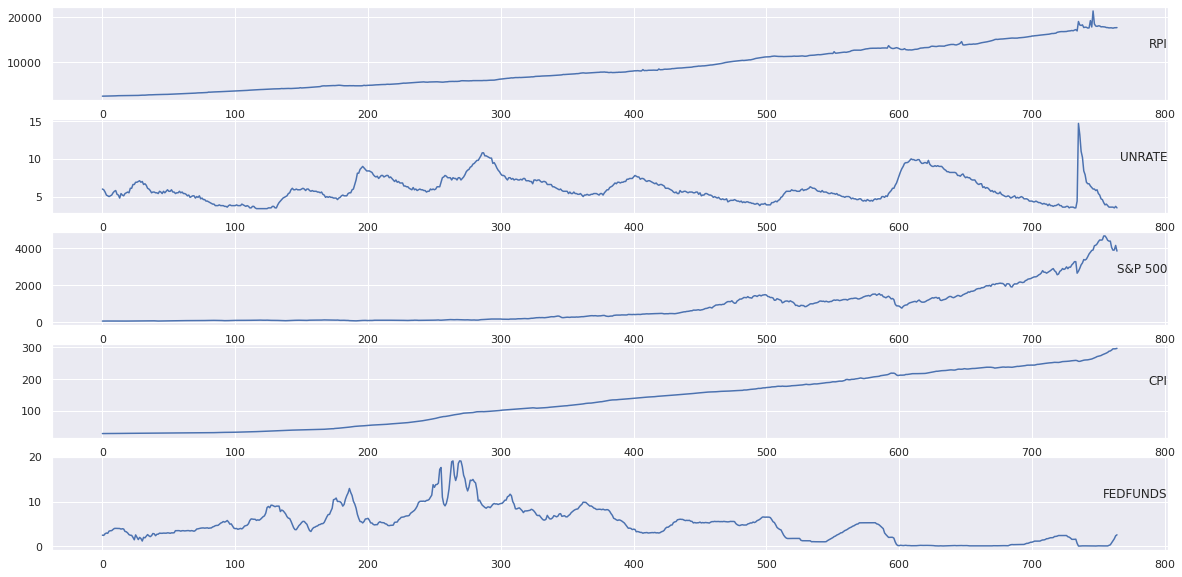

In [ ]:
values = fred.values
groups = [0, 1, 2, 3,4]
i = 1
# plot each column
rcParams['figure.figsize'] = 20, 10
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(fred.columns[group], y=0.5, loc='right')
    i += 1


plt.show()


## Real Personal Income

<Figure size 4000x1600 with 0 Axes>

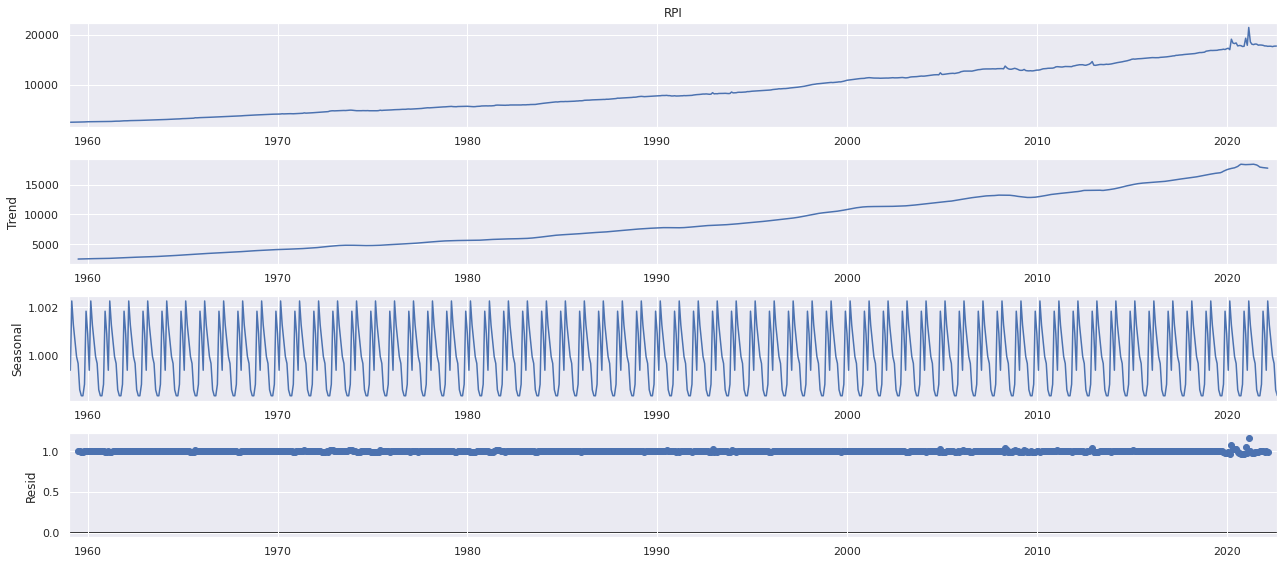

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = fred[df.columns.values[0]][:]
result = seasonal_decompose(series, model='multiplicative')
result.plot();

## Unemployment Rate

<Figure size 4000x1600 with 0 Axes>

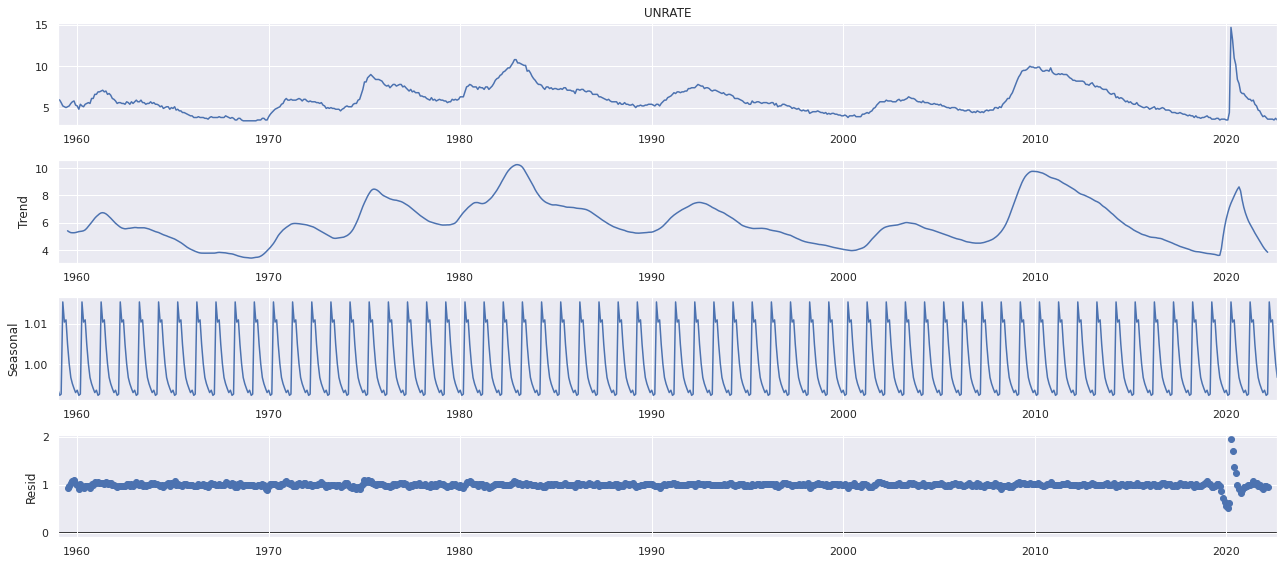

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = fred[df.columns.values[1]][:]
result = seasonal_decompose(series, model='multiplicative')
result.plot();

## Stock Price Index

<Figure size 4000x1600 with 0 Axes>

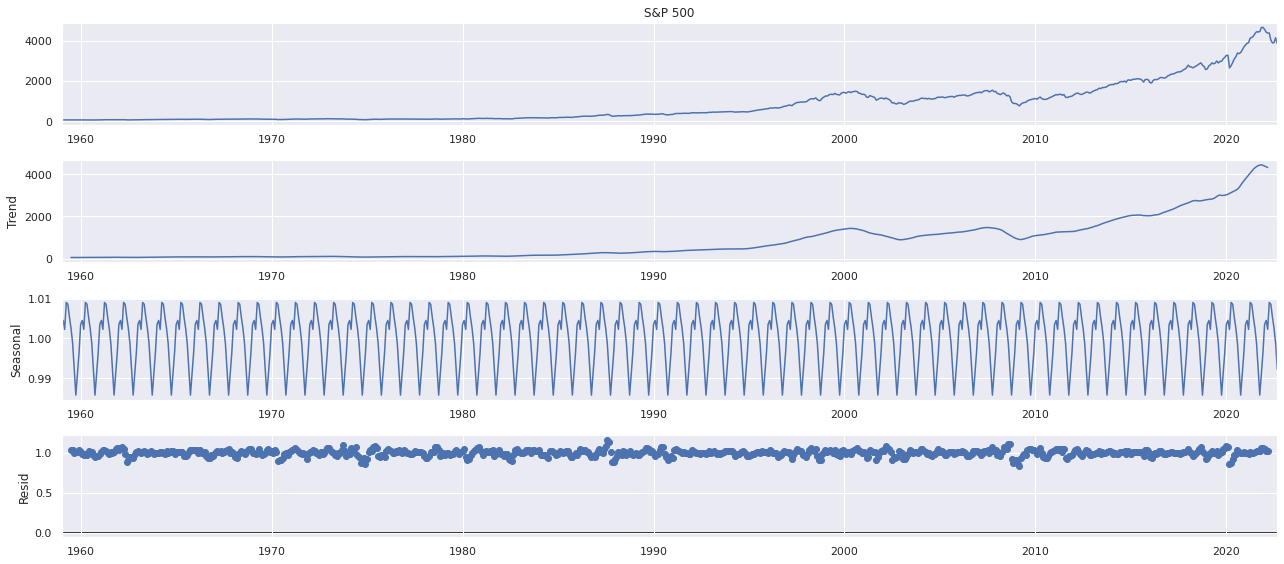

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = fred[df.columns.values[2]][:]
result = seasonal_decompose(series, model='multiplicative')
result.plot();

## Consumer Price Index

<Figure size 4000x1600 with 0 Axes>

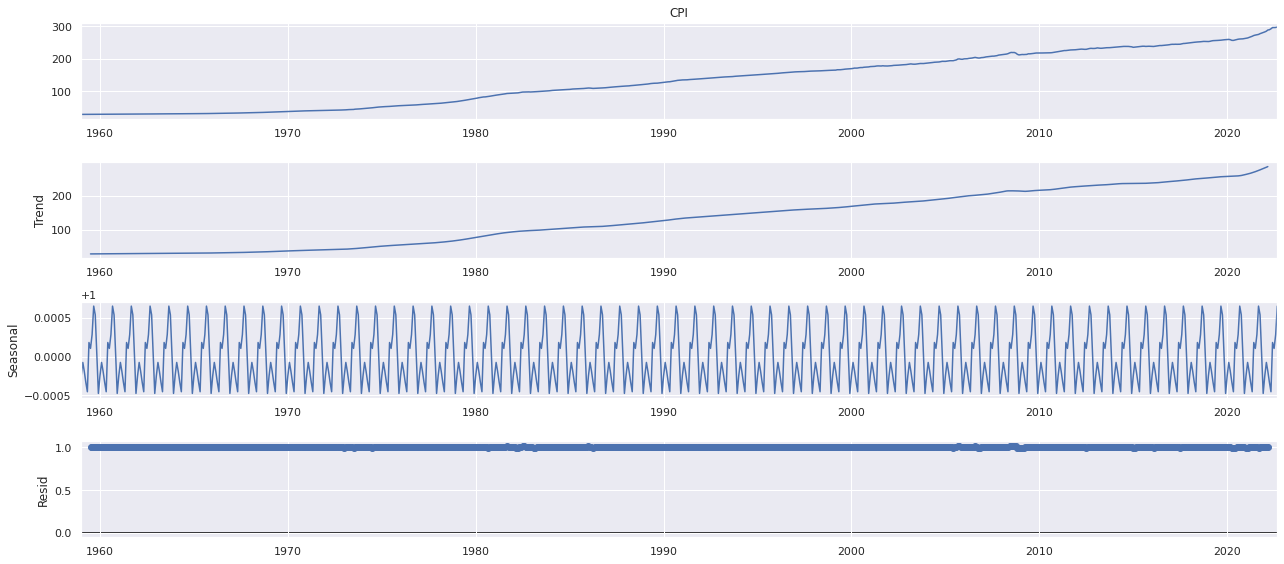

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = fred[df.columns.values[3]][:]
result = seasonal_decompose(series, model='multiplicative')
result.plot();

## Federal Funds Rate

<Figure size 4000x1600 with 0 Axes>

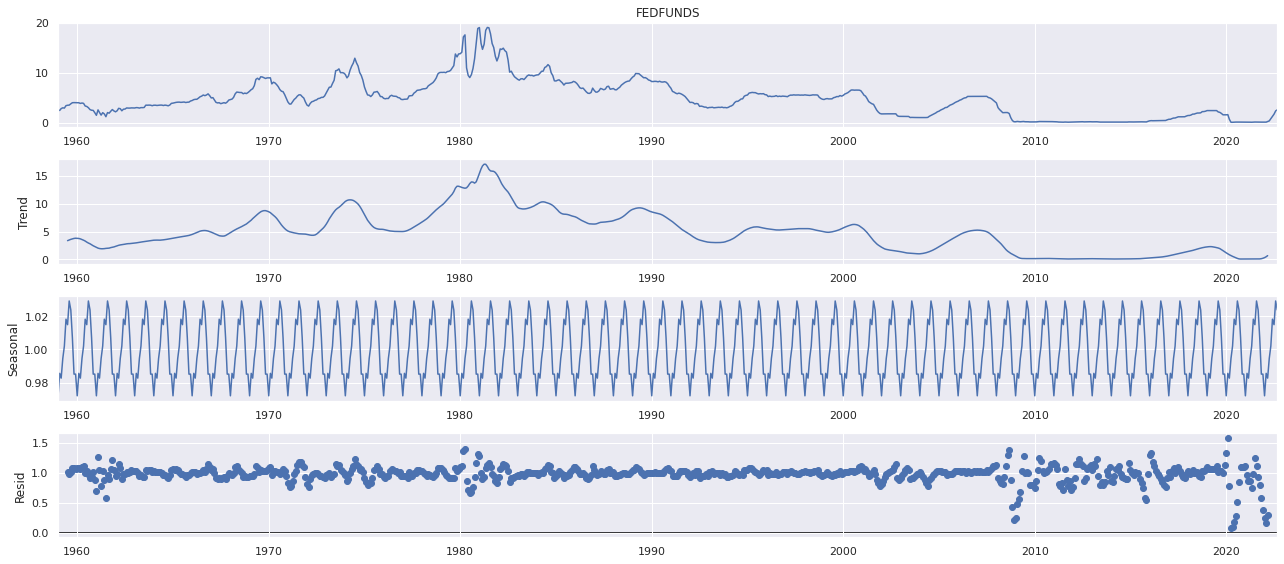

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = fred[df.columns.values[4]][:]
result = seasonal_decompose(series, model='multiplicative')
result.plot();

# Creating testing functions

In [ ]:
# Stationarity Tests
def Stationarity_Tests(value, test):
    st=0
    if test== 'ADF': 
        print ('Results of Augmented Dickey-Fuller Test:')
        result = adfuller(value, autolag='AIC')
        # print(result)
        result1 = ADF(value, trend='c', method='aic')
        print(result1.summary())
        print('\n')
        print('ADF Statistic: %f' % result[0])
        if result[1] < 0.1: #result[4]["10%"]:
            print ("Reject Ho - Time Series is Stationary")
            st=1
        else:
            print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    elif test=='KPSS':
        print("Results of KPSS Test:\n")
        
        result=kpss(value, regression='c')
        # print(result)
        result1= KPSS(value, trend='c')
        print(result1.summary())
        print('\n')
        if result[1] < 0.1: #result[3]["10%"]:
            print ("Reject Ho - Time Series contains a unit root")
        else:
            print ("Failed to Reject Ho - Time Series is weakly stationary.")
            st=1

    elif test=='PP':
        print("Results of Phillips Perron Test:\n")
        result1= PhillipsPerron(value, trend='c')
        print(result1.summary(), '\n')
        print('\n')

In [ ]:
# Structural Breaks"
def Structural_Break_tests(value, test, yr=None):
    if test=='ZA': 
        print("Results of Zivot Andrews Test:\n")
        result=zivot_andrews(value, regression='c', autolag='aic')
        a={"Test Statistic": result[0], "p-value": result[1], "Lags Used": result[3]}
        print('Null Hypothesis: Unit root with a drift')
        print('Alternative Hypothesis: Stationary process with one time break')


        za_output = pd.Series(a)
        for key, value in result[2].items():
            za_output["Critical Value (%s)" % key] = value
        if result[0] < result[2]["10%"]:
            print ("Reject Ho - Stationary process with one-time break in the level")
        else:
            print ("Failed to Reject Ho -Unit root series with drift")
        print(za_output)


In [ ]:
# Granger Causality Test
def Granger_Causality_Test(data, variables, test='ssr_chi2test', verbose=False):
    print("Results of Granger Causality Test:\n")
    g_causalitymatrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in g_causalitymatrix.columns:
        for r in g_causalitymatrix.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=12, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(12)]
            
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            g_causalitymatrix.loc[r, c] = min_p_value
    g_causalitymatrix.columns = [var + '_x' for var in variables]
    g_causalitymatrix.index = [var + '_y' for var in variables]

    print(g_causalitymatrix)
    fig, ax = plt.subplots(figsize=(7, 7))         # Sample figsize in inches
    sns.heatmap(g_causalitymatrix, annot=False, linewidths=.5, ax=ax)

    # ax=sns.heatmap(, linewidth=0.5)
    plt.show()



In [ ]:
# Cointegration Tests:

# df1=pd.DataFrame({'x':df['RPI'],
#                   'y':df['UNRATE']})

def Cointegration_Tests(data, variables, test=None, verbose=None):
    if test=='Johansen':
        print('Results of Johansen Cointegration Test')
        # def joh_output(res):
        #     output = pd.DataFrame([res.lr2,res.lr1],
        #                           index=['max_eig_stat',"trace_stat"])
        #     print(output.T,'\n')
        #     print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
        #     print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
        
        def joh_output(res):
            output = pd.DataFrame([res.lr2,res.lr1],
                                  index=['max_eig_stat',"trace_stat"])
            print(output.T,'\n')
            print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
            print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
            print('\nEigen Value Statistics')
            if res.lr2[0]<res.cvm[0][1]:
                print('Accept Null Hypothesis at 95% Confidence Interval:\n  No Cointegration')
            else:
                print('Reject Null Hypothesis at 95% Confidence Interval:\n  Cointegration exists')
            
            print('\nTrace Statistics')
            if res.lr1[0]<res.cvt[0][1]:
                print('Accept Null Hypothesis at 95% Confidence Interval:\n  No Cointegration')
            else:
                print('Reject Null Hypothesis at 95% Confidence Interval:\n  Cointegration exists')

        # Model 3 (2 lag-difference used = 3 lags VAR or VAR(3) model) with constant/trend (deterministc) term
        joh_model3 = coint_johansen(data,det_order = 0,k_ar_diff=2) 
        joh_output(joh_model3)
        
        # Model 2: with linear trend only
        joh_model2 = coint_johansen(data,1,2) 
        joh_output(joh_model2)
        
        # Model 1: no constant/trend (deterministc) term
        joh_model1 = coint_johansen(data,-1,2) 
        joh_output(joh_model1)




# joh_model3 = coint_johansen(df1,det_order = 0,k_ar_diff=1) # k_ar_diff +1 = K
# joh_output(joh_model3)


#0: Null Hypothesis: No cointegration
#1: Cointegration exists

In [ ]:
# Engel and Granger Cointegration

coint_result = coint(df['RPI'], df['UNRATE'])
print('T-Statistic:', coint_result[0])
print('P-value:', coint_result[1])
print('Critical Value at 99% CI:', coint_result[2][0])
print('Critical Value at 95% CI:', coint_result[2][1])
print('Critical Value at 90% CI:', coint_result[2][2])
if coint_result[1] < 0.05:
    print('Reject Null Hypothesis: Cointegration exists')
else:
    print('Accept Null Hypothesis: No Cointegration')

T-Statistic: 0.5079068346147999
P-value: 0.9927012953630109
Critical Value at 99% CI: -3.9108323867903843
Critical Value at 95% CI: -3.3441392023930265
Critical Value at 90% CI: -3.0500059688605026
Accept Null Hypothesis: No Cointegration


# Testing Data

## Stationarity Tests

### Augmented Dickey Fuller Test

In [ ]:
a = df.columns.values
a1 = df1.columns.values


print('ADF')
for x in a:
    print(x)
    Stationarity_Tests(df[x], 'ADF')
    print('\n')

ADF
RPI
Results of Augmented Dickey-Fuller Test:
   Augmented Dickey-Fuller Results   
Test Statistic                  2.943
P-value                         1.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ADF Statistic: 2.943442
Failed to Reject Ho - Time Series is Non-Stationary


UNRATE
Results of Augmented Dickey-Fuller Test:
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.398
P-value                         0.011
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ADF Statistic: -3.398082
Reject Ho - Time Series is Stationary


S&P 500
Results of

In [ ]:
print('ADF')
for x in a1:
    print(x)
    Stationarity_Tests(df1[x], 'ADF')
    print('\n')

ADF
RPI_diff
Results of Augmented Dickey-Fuller Test:
   Augmented Dickey-Fuller Results   
Test Statistic                 -6.065
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ADF Statistic: -6.065309
Reject Ho - Time Series is Stationary


CPI_diff
Results of Augmented Dickey-Fuller Test:
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.503
P-value                         0.115
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ADF Statistic: -2.503226
Failed to Reject Ho - Time Series is Non-Stationary


FEDFUNDS_d

### KPSS Test

In [ ]:
print('KPSS')
for x in a:
    print(x)
    Stationarity_Tests(df[x], 'KPSS')
    print('\n')

KPSS
RPI
Results of KPSS Test:

    KPSS Stationarity Test Results   
Test Statistic                  4.244
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


Reject Ho - Time Series contains a unit root


UNRATE
Results of KPSS Test:

    KPSS Stationarity Test Results   
Test Statistic                  0.200
P-value                         0.268
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


Failed to Reject Ho - Time Series is weakly stationary.


S&P 500
Results of KPSS Test:

    KPSS Stationarity Test Results   
Test Statistic              

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning

In [ ]:
print('KPSS')
for x in a1:
    print(x)
    Stationarity_Tests(df1[x], 'KPSS')
    print('\n')

KPSS
RPI_diff
Results of KPSS Test:

    KPSS Stationarity Test Results   
Test Statistic                  0.460
P-value                         0.050
Lags                              108
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


Reject Ho - Time Series contains a unit root


CPI_diff
Results of KPSS Test:

    KPSS Stationarity Test Results   
Test Statistic                  1.109
P-value                         0.001
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


Reject Ho - Time Series contains a unit root


FEDFUNDS_diff
Results of KPSS Test:

    KPSS Stationarity Test Results   
Test Statistic            

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


### Philips Perron Test

In [ ]:
print('PP')
print('if p<0.05: Reject Null Hypothesis')
for x in a:
    print(x)
    Stationarity_Tests(df[x], 'PP')
    print('\n')

PP
if p<0.05: Reject Null Hypothesis
RPI
Results of Phillips Perron Test:

     Phillips-Perron Test (Z-tau)    
Test Statistic                  1.596
P-value                         0.998
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 





UNRATE
Results of Phillips Perron Test:

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.613
P-value                         0.006
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 





S&P 500
Results of Phillips Perron Test:

     Phillips-Perron Test (Z-tau)    
Test Statistic                  2.082
P-value         

In [ ]:
print('PP')
# a1 = df1.columns.values

print('if p<0.05: Reject Null Hypothesis')
for x in a1:
    print(x)
    Stationarity_Tests(df1[x], 'PP')
    print('\n')

PP
if p<0.05: Reject Null Hypothesis
RPI_diff
Results of Phillips Perron Test:

     Phillips-Perron Test (Z-tau)    
Test Statistic                -62.705
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 





CPI_diff
Results of Phillips Perron Test:

     Phillips-Perron Test (Z-tau)    
Test Statistic                -17.246
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 





FEDFUNDS_diff
Results of Phillips Perron Test:

     Phillips-Perron Test (Z-tau)    
Test Statistic                -17.392
P-v

## Structural Break Test

### Zivot Andrews Test

In [ ]:
a = df.columns.values
a1 = df1.columns.values


print('Zivot Andrews Structural Break Test')
for x in a:
    print(x)
    Structural_Break_tests(df[x], 'ZA')
    print('\n')
    # Structural_Break_tests(df['S&P 500'], 'ZA', yr=None)

Zivot Andrews Structural Break Test
RPI
Results of Zivot Andrews Test:

Null Hypothesis: Unit root with a drift
Alternative Hypothesis: Stationary process with one time break
Failed to Reject Ho -Unit root series with drift
Test Statistic          -1.739551
p-value                  0.999000
Lags Used               20.000000
Critical Value (1%)     -5.276440
Critical Value (5%)     -4.810670
Critical Value (10%)    -4.566180
dtype: float64


UNRATE
Results of Zivot Andrews Test:

Null Hypothesis: Unit root with a drift
Alternative Hypothesis: Stationary process with one time break
Failed to Reject Ho -Unit root series with drift
Test Statistic         -4.028114
p-value                 0.335084
Lags Used               2.000000
Critical Value (1%)    -5.276440
Critical Value (5%)    -4.810670
Critical Value (10%)   -4.566180
dtype: float64


S&P 500
Results of Zivot Andrews Test:

Null Hypothesis: Unit root with a drift
Alternative Hypothesis: Stationary process with one time break
Failed

## Auto Correlation and Partial Autocorrelation Plots

In [ ]:
def stat_plot(col):
    plt.rcParams.update({'figure.figsize':(29,15), 'figure.dpi':120})

    # Original Series
    fig, axes = plt.subplots(3, 3)
    axes[0, 0].plot(df[col])
    axes[0, 0].set_title('Original Series')
    plot_acf(df[col], ax=axes[0, 1])
    plot_pacf(df[col], ax=axes[0, 2])

    # 1st Differencing
    axes[1, 0].plot(df[col].diff())
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df[col].diff().dropna(), ax=axes[1, 1])
    plot_pacf(df[col].diff().dropna(), ax=axes[1, 2])


    # 2nd Differencing
    axes[2, 0].plot(df[col].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df[col].diff().diff().dropna(), ax=axes[2, 1])
    plot_pacf(df[col].diff().diff().dropna(), ax=axes[2, 2])


    plt.show()

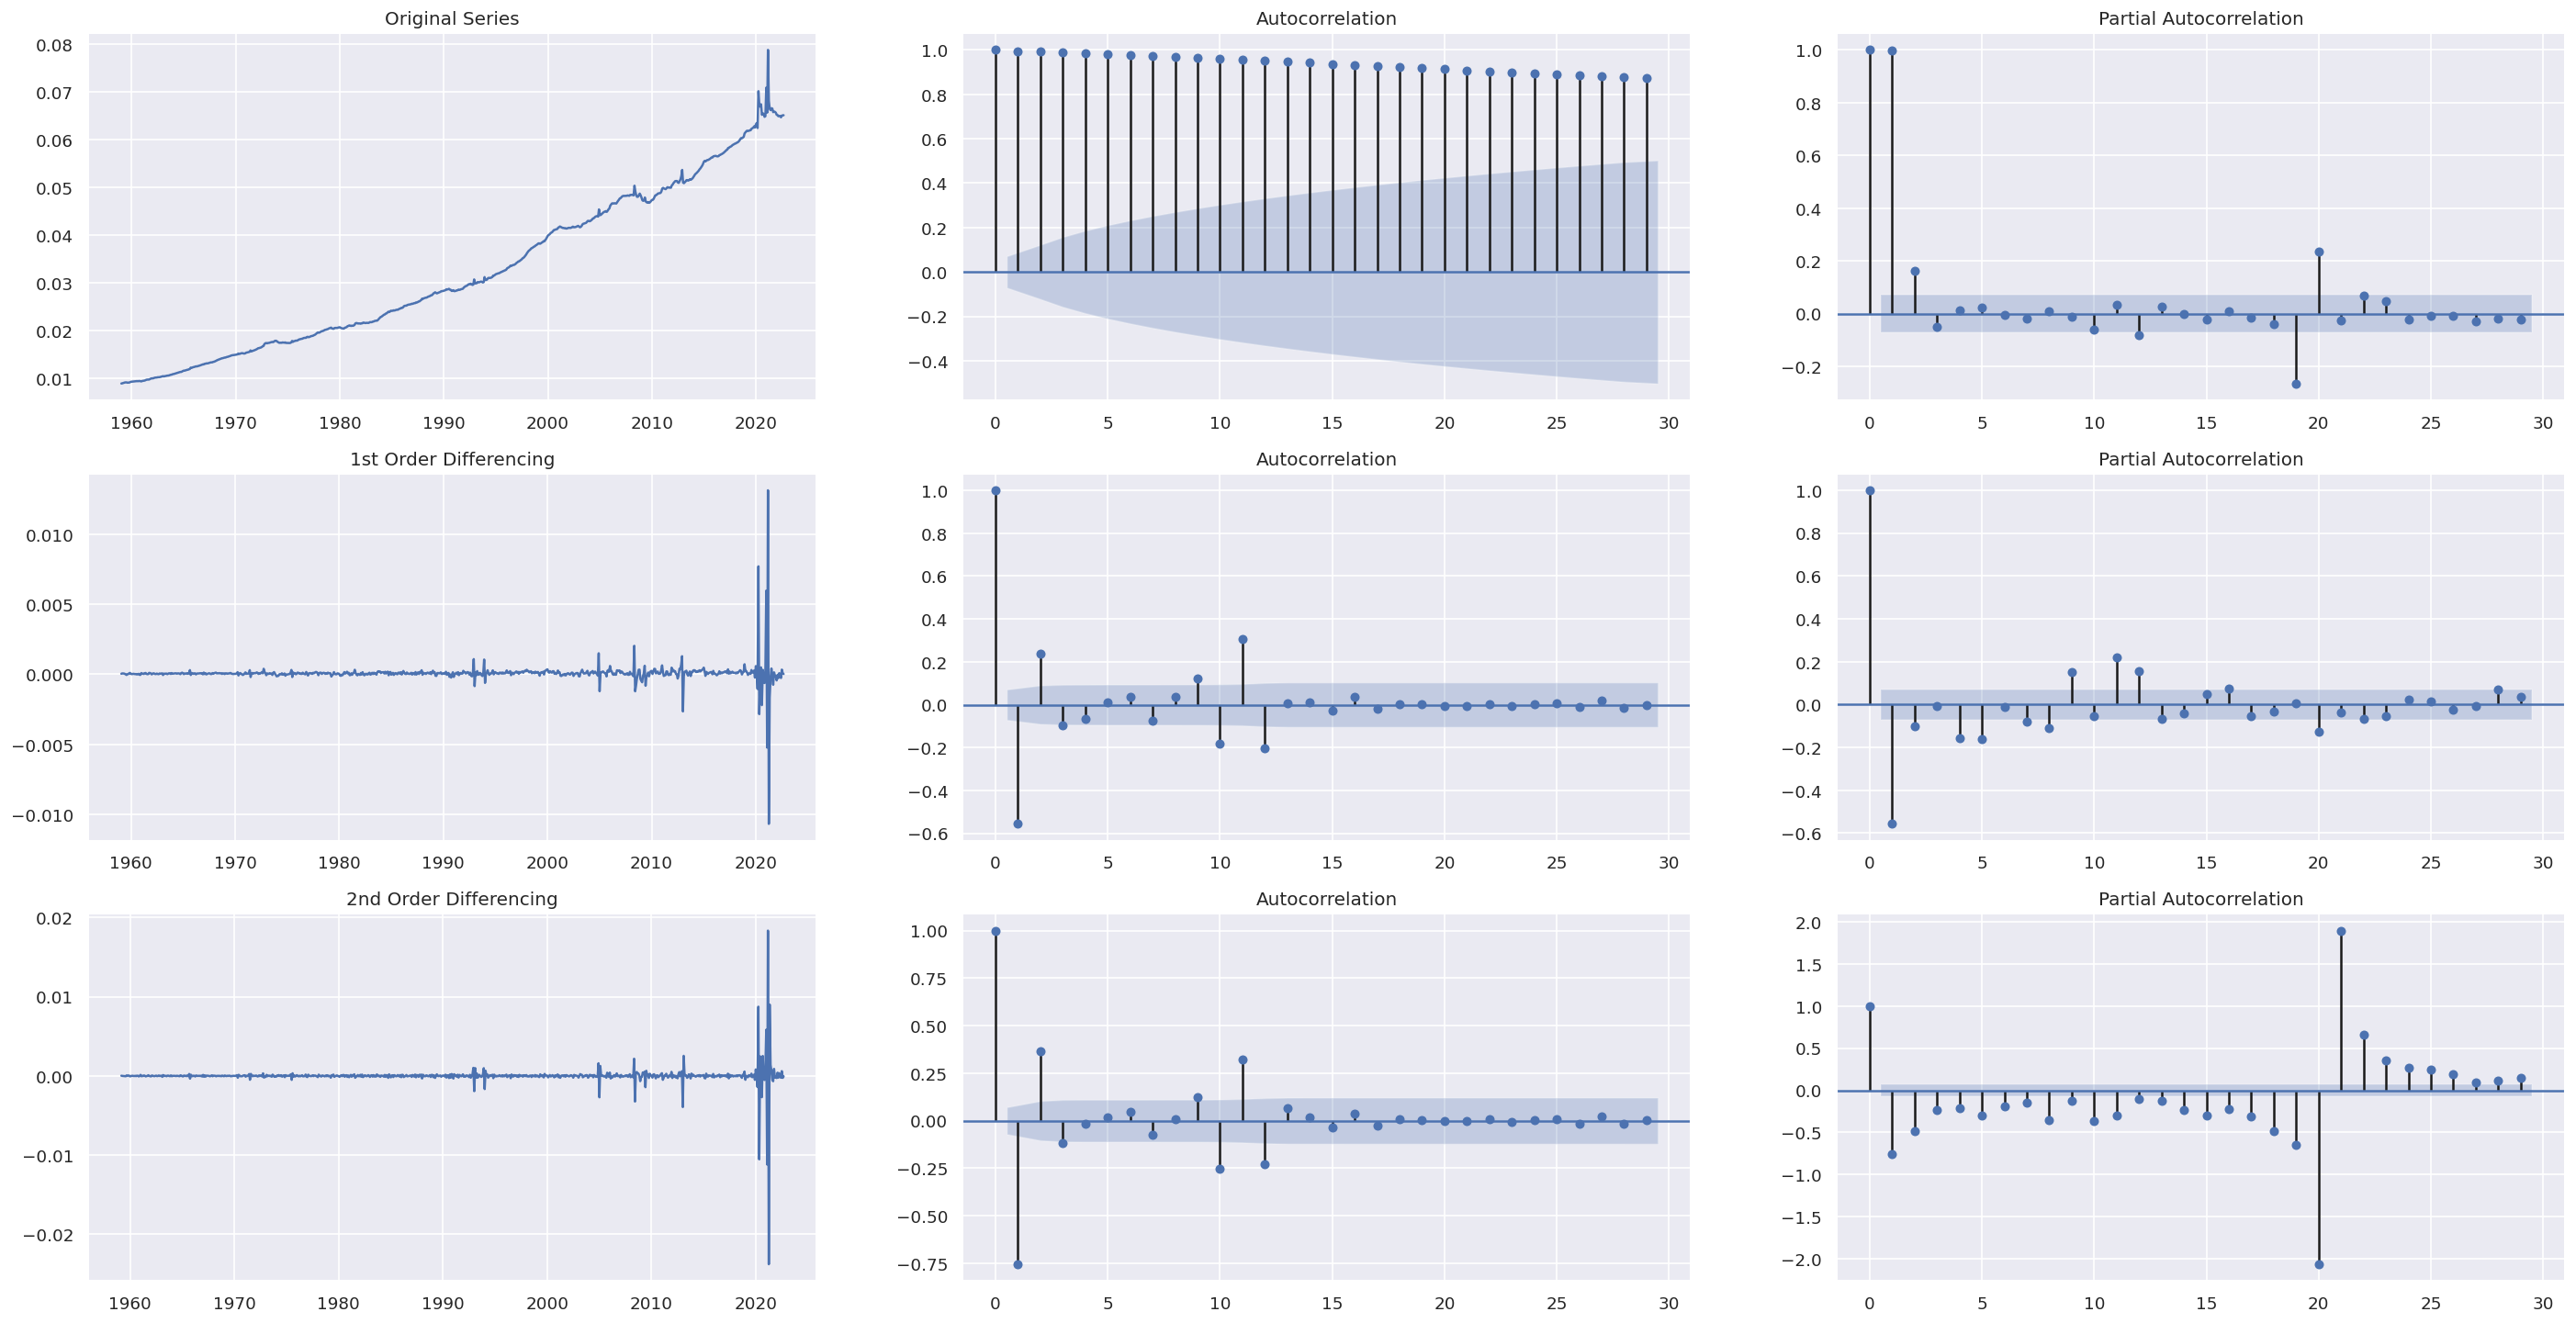

In [ ]:
stat_plot('RPI')

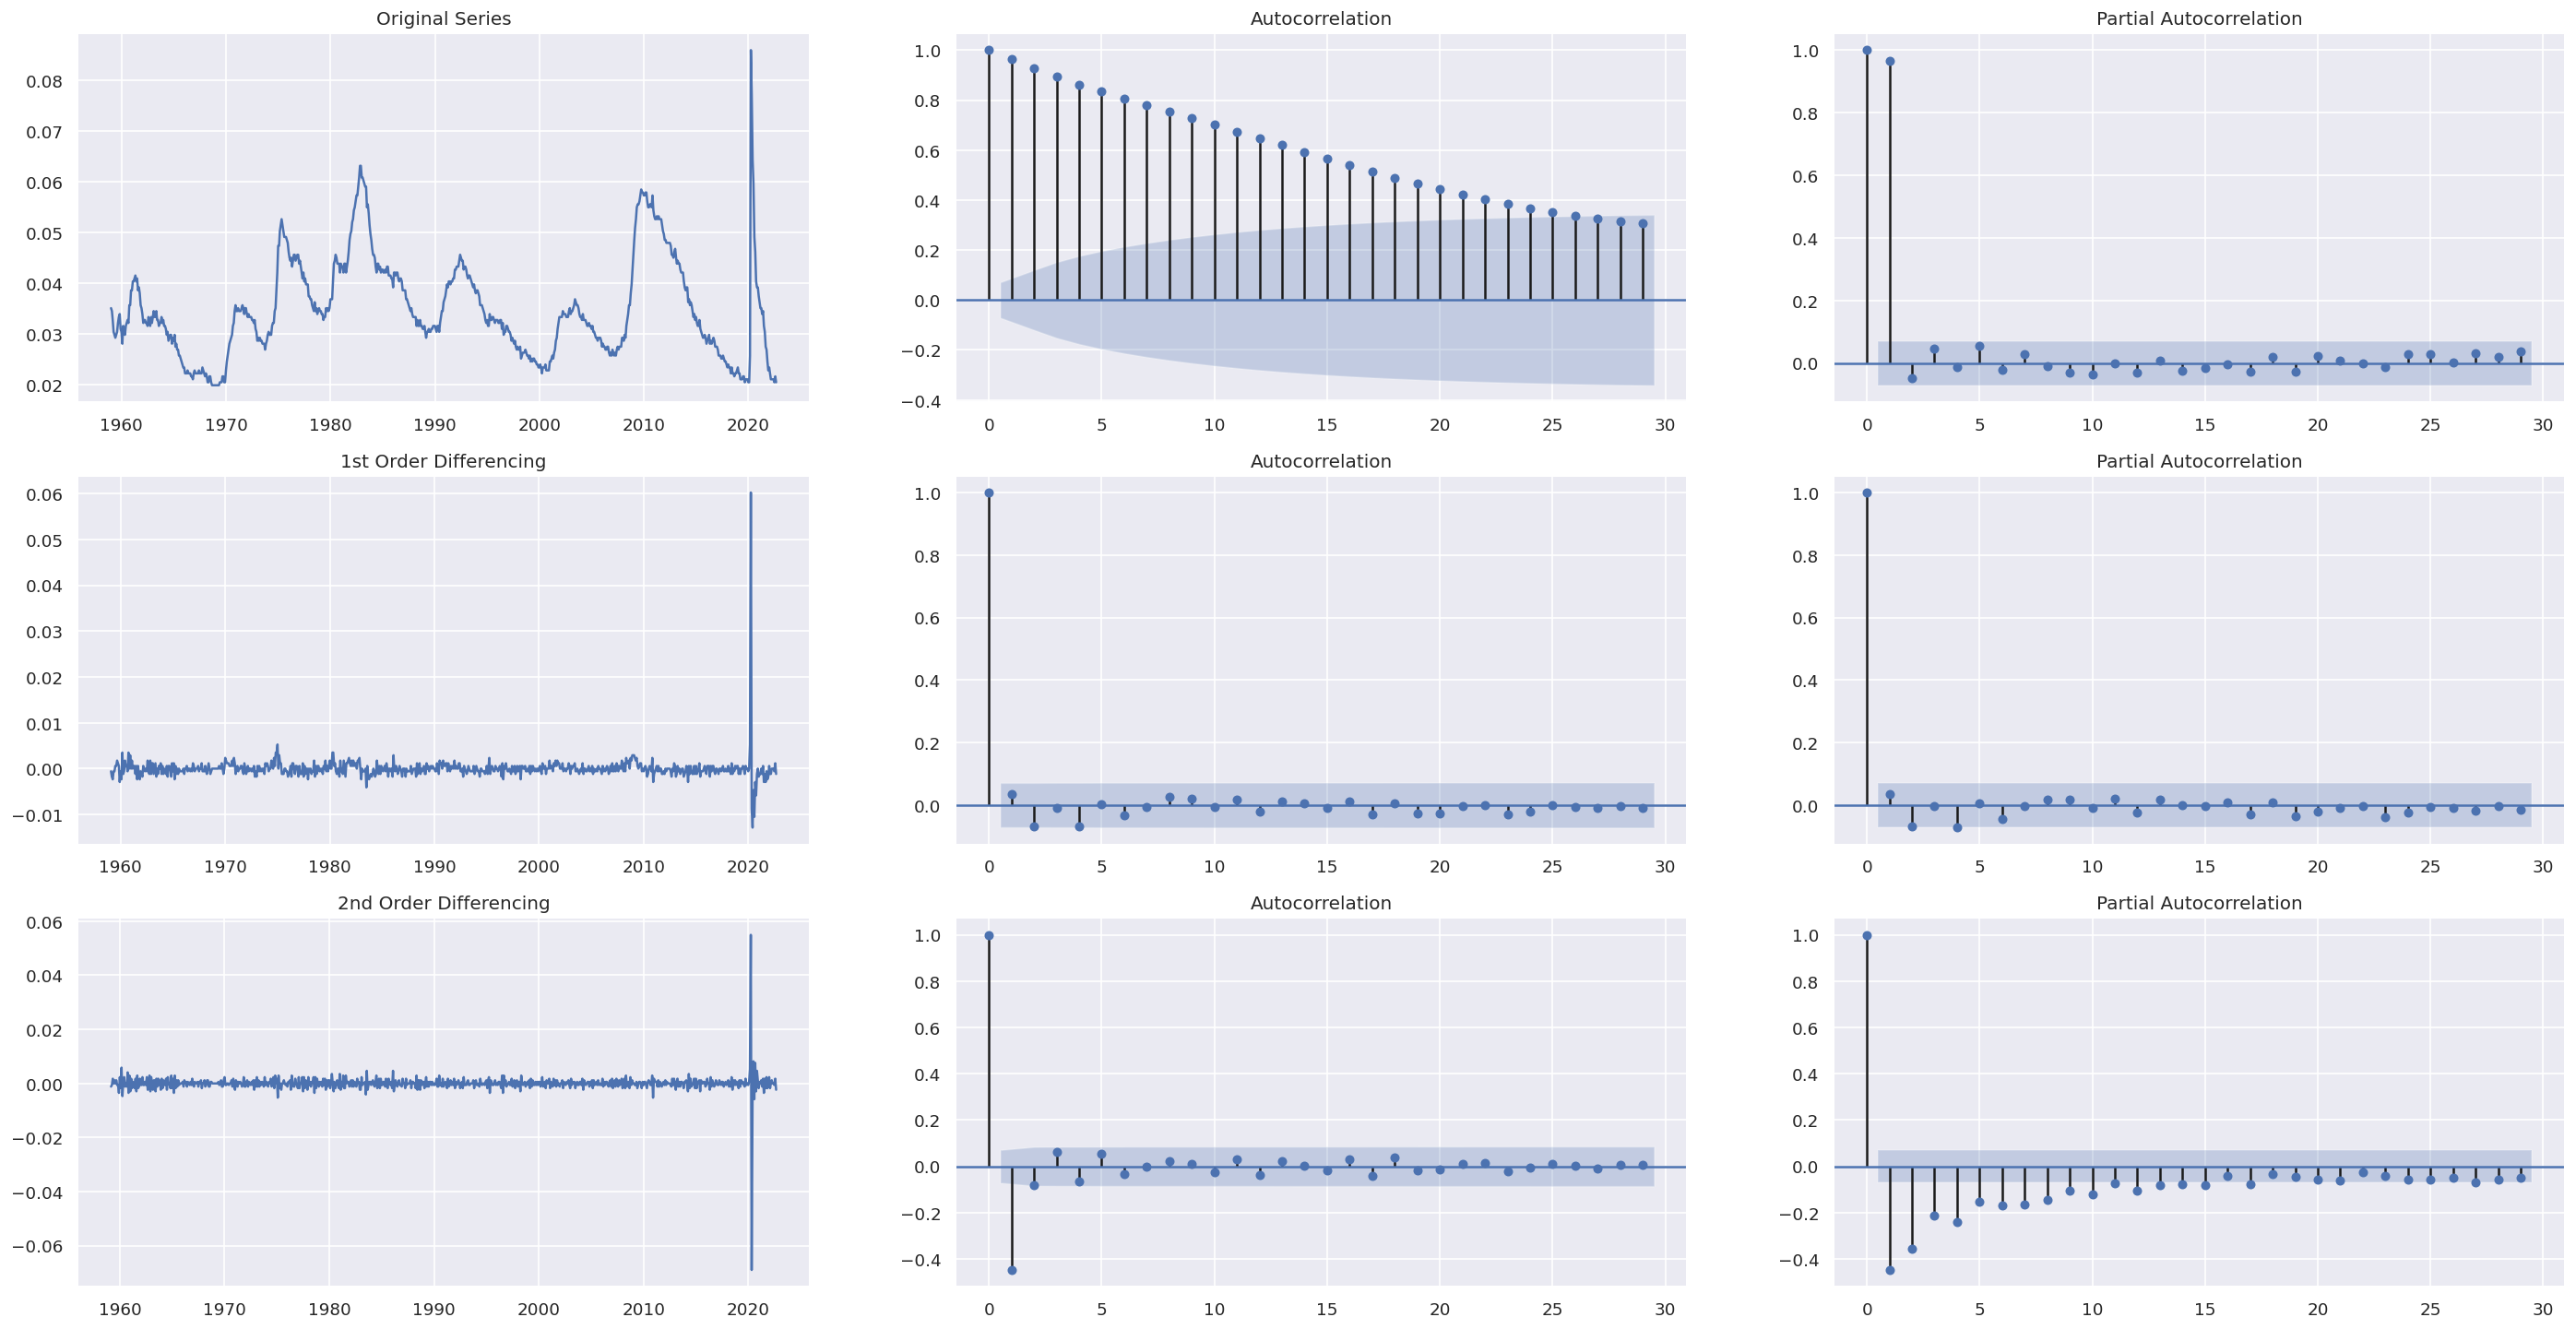

In [ ]:
stat_plot('UNRATE')

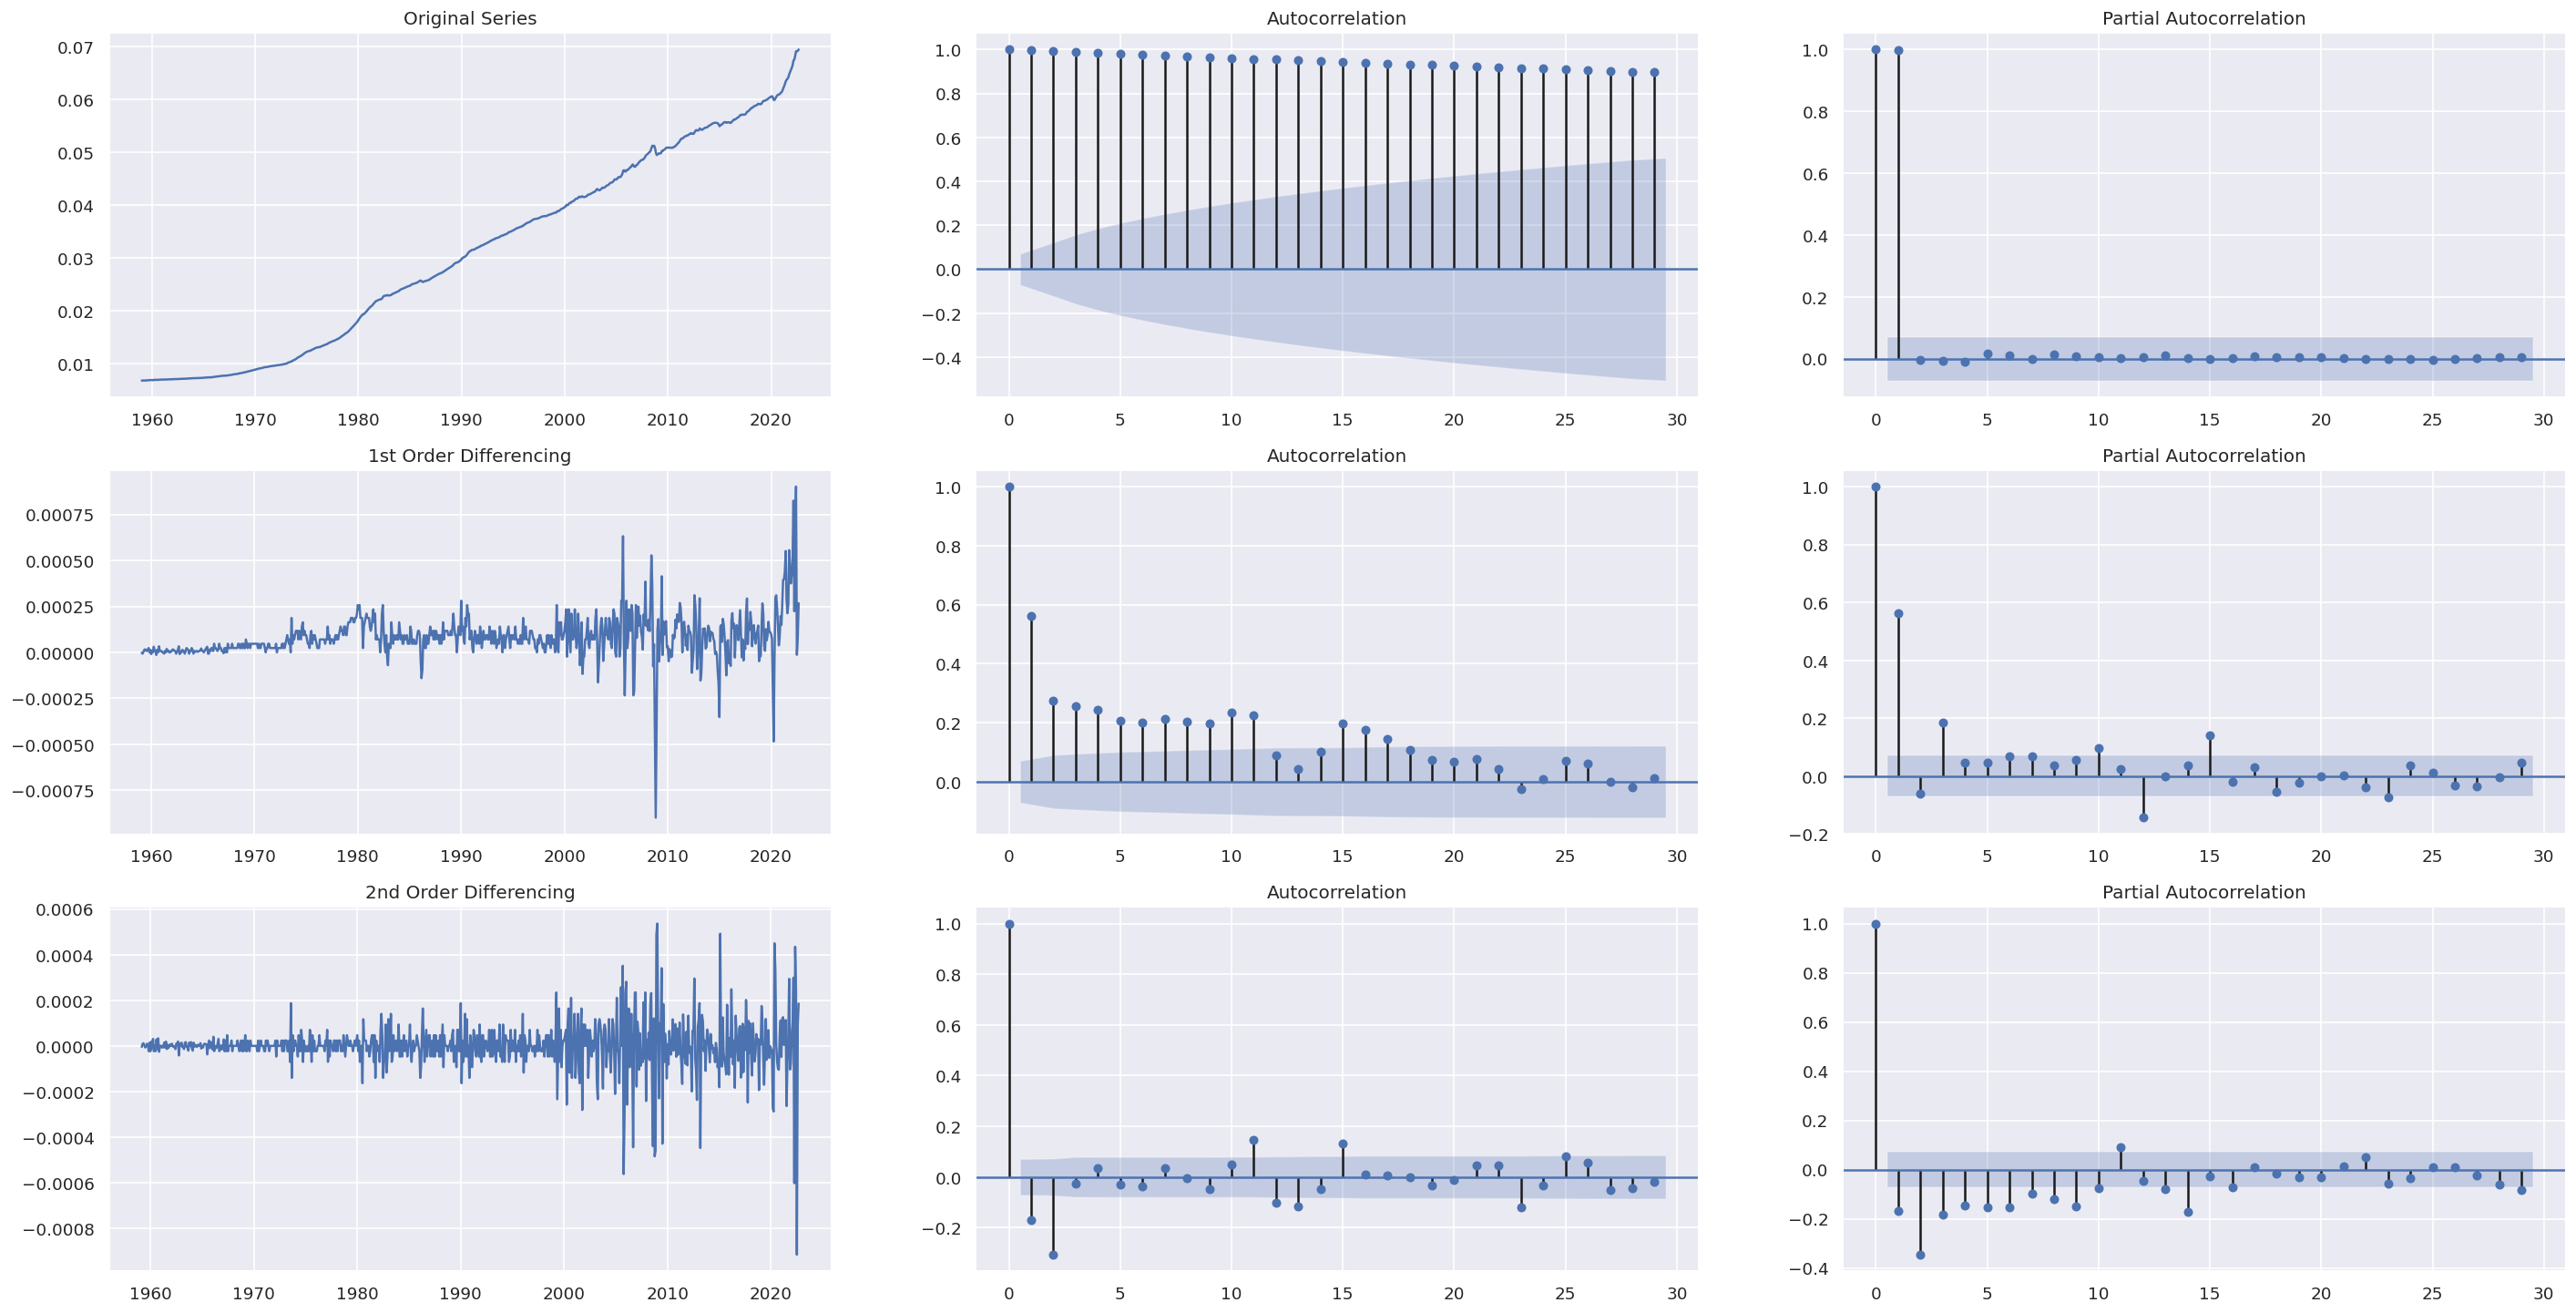

In [ ]:
stat_plot('CPI')

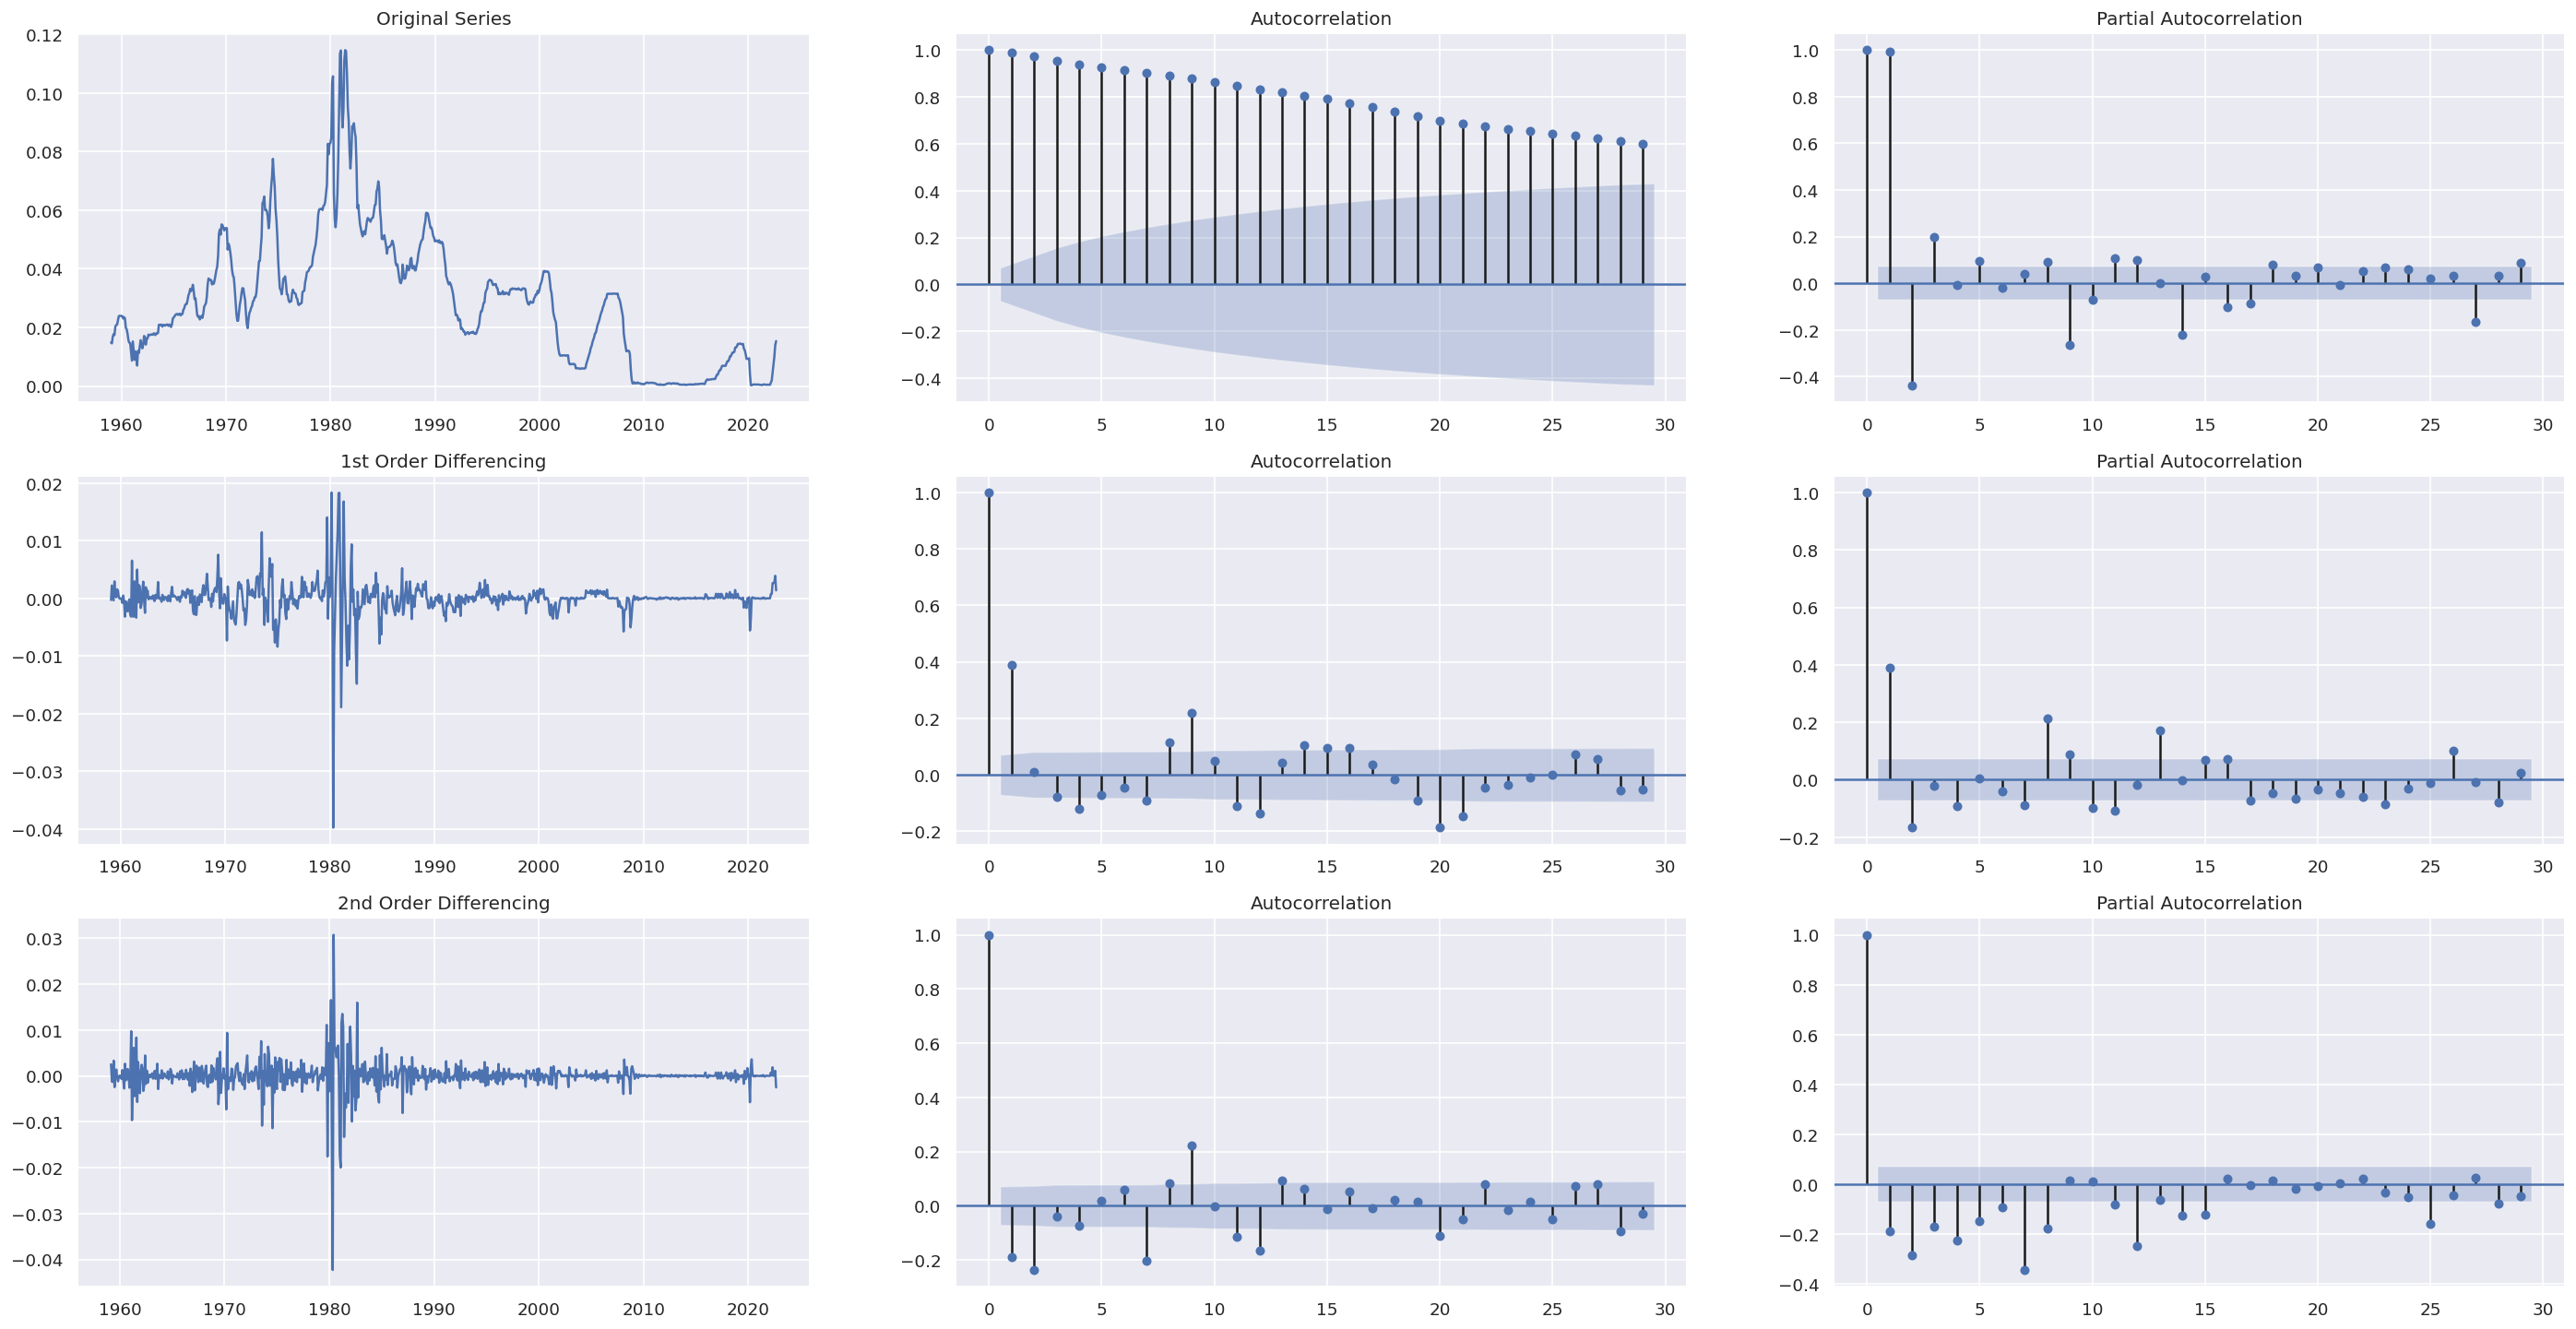

In [ ]:
stat_plot('FEDFUNDS')

## Granger Causality Test

Results of Granger Causality Test:

             RPI_x  UNRATE_x  S&P 500_x   CPI_x  FEDFUNDS_x
RPI_y       1.0000    0.0000     0.0000  0.0000      0.6650
UNRATE_y    0.0017    1.0000     0.0000  0.0176      0.0004
S&P 500_y   0.0000    0.0000     1.0000  0.0000      0.2659
CPI_y       0.0000    0.3849     0.0000  1.0000      0.0000
FEDFUNDS_y  0.0768    0.0424     0.1334  0.0385      1.0000


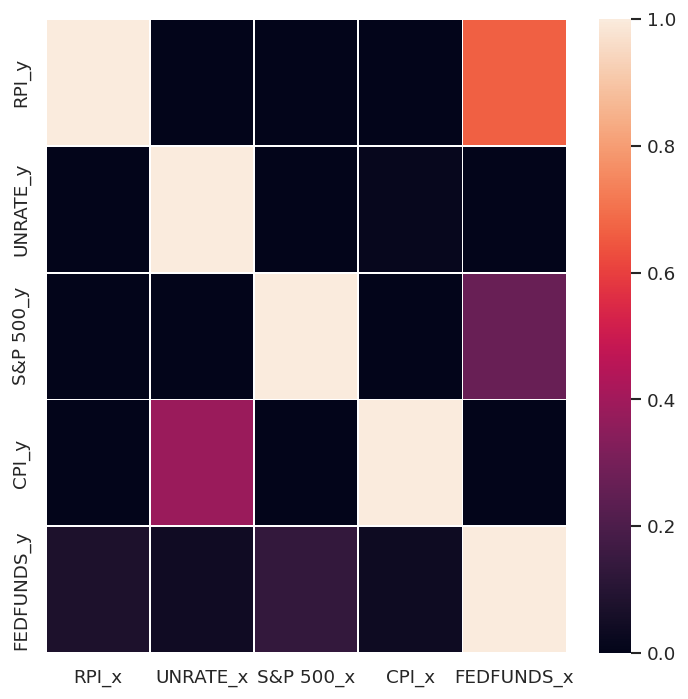

In [ ]:
Granger_Causality_Test(df, df.columns, test='ssr_chi2test', verbose=False)

## Cointegration Tests

In [ ]:
co_ma = pd.DataFrame(columns=df.columns)
co_ma['Tests'] = df.columns
co_ma.set_index('Tests', drop=True, inplace=True)
co_ma

,RPI,UNRATE,S&P 500,CPI,FEDFUNDS
Tests,,,,,
RPI,NaN,NaN,NaN,NaN,NaN
UNRATE,NaN,NaN,NaN,NaN,NaN
S&P 500,NaN,NaN,NaN,NaN,NaN
CPI,NaN,NaN,NaN,NaN,NaN
FEDFUNDS,NaN,NaN,NaN,NaN,NaN


In [ ]:
# JOHANSEN COINTEGRATION
c = 'Cointegration'
n = 'No Cointegration'
def joh(col1, col2):

    df_co=pd.DataFrame({'x':df[col1],
                      'y':df[col2]})
    joh_model3 = coint_johansen(df_co,det_order = 0,k_ar_diff=1) # k_ar_diff +1 = K

    output = pd.DataFrame([joh_model3.lr2,joh_model3.lr1],
                          index=['max_eig_stat',"trace_stat"])
    # print(output.T,'\n')
    # print("Critical values(90%, 95%, 99%) of max_eig_stat\n",joh_model3.cvm,'\n')
    # print("Critical values(90%, 95%, 99%) of trace_stat\n",joh_model3.cvt,'\n')
    # print('\nEigen Value Statistics')
    if joh_model3.lr2[0]<joh_model3.cvm[0][1]:
        # print('Accept Null Hypothesis at 95% Confidence Interval:\n  No Cointegration')
        co_ma[col2][col1]=n
    else:
        # print('Reject Null Hypothesis at 95% Confidence Interval:\n  Cointegration exists')
        co_ma[col2][col1]=c
    
    # print('\nTrace Statistics')
    # if joh_model3.lr1[0]<joh_model3.cvt[0][1]:
        # print('Accept Null Hypothesis at 95% Confidence Interval:\n  No Cointegration')

    # else:
        # print('Reject Null Hypothesis at 95% Confidence Interval:\n  Cointegration exists')


for i in df.columns:
    for j in df.columns:
        if i != j:
            joh(i, j)
# joh('FEDFUNDS', 'RPI')
# for i in df.columns.drop('FEDFUNDS'):
#     joh('FEDFUNDS', i)
    # print(i)
for i in df.columns:
    co_ma[i][i] = 0

co_ma
#0: Null Hypothesis: No cointegration
#1: Cointegration exists

,RPI,UNRATE,S&P 500,CPI,FEDFUNDS
Tests,,,,,
RPI,0,No Cointegration,No Cointegration,Cointegration,No Cointegration
UNRATE,No Cointegration,0,Cointegration,Cointegration,Cointegration
S&P 500,No Cointegration,Cointegration,0,Cointegration,No Cointegration
CPI,Cointegration,Cointegration,Cointegration,0,Cointegration
FEDFUNDS,No Cointegration,Cointegration,No Cointegration,Cointegration,0


In [ ]:
joh('UNRATE', 'CPI')


In [ ]:
# COINTEGRATION

coint_result = coint(df['CPI'], df['UNRATE'])
print('T-Statistic:', coint_result[0])
print('P-value:', coint_result[1])
print('Critical Value at 99% CI:', coint_result[2][0])
print('Critical Value at 95% CI:', coint_result[2][1])
print('Critical Value at 90% CI:', coint_result[2][2])
if coint_result[1] < 0.05:
    print('Reject Null Hypothesis: Cointegration exists')
else:
    print('Accept Null Hypothesis: No Cointegration')



T-Statistic: 1.0972810728102371
P-value: 1.0
Critical Value at 99% CI: -3.9108323867903843
Critical Value at 95% CI: -3.3441392023930265
Critical Value at 90% CI: -3.0500059688605026
Accept Null Hypothesis: No Cointegration


In [ ]:
# COINTEGRATION
# Generalize this in the form of a function

coint_result = coint(df['UNRATE'], df['CPI'])
print('T-Statistic:', coint_result[0])
print('P-value:', coint_result[1])
print('Critical Value at 99% CI:', coint_result[2][0])
print('Critical Value at 95% CI:', coint_result[2][1])
print('Critical Value at 90% CI:', coint_result[2][2])
if coint_result[1] < 0.05:
    print('Reject Null Hypothesis: Cointegration exists')
else:
    print('Accept Null Hypothesis: No Cointegration')



T-Statistic: -3.388599302411248
P-value: 0.04363261153530837
Critical Value at 99% CI: -3.9108323867903843
Critical Value at 95% CI: -3.3441392023930265
Critical Value at 90% CI: -3.0500059688605026
Reject Null Hypothesis: Cointegration exists


# In-Sample Forecast

## Vector Auto Regression

### Prediction from October 2012 to September 2022

The VAR model uses 4 variables: Consumer Price Index, real personal income, unemployment rate, Fed Funds rate and Stock Price Index.

The VAR model uses 12 lags for each variable and predicts each variable from Oct 2012 to Sept 2022.
$B$ represents a matrix of coefficients.


$$
\begin{bmatrix} \\ cpi_{t} \\ rpi_{t} \\ unemp_{t} \\ fedrate_{t}\\ s\&p_{t}\end{bmatrix} = \alpha_t + B_{t-1}\begin{bmatrix} \\cpi_{t-1} \\ rpi_{t-1} \\ unemp_{t-1} \\ fedrate_{t-1}\\ s\&p_{t-1} \end{bmatrix} + \dots + B_{t-12}\begin{bmatrix} \\cpi_{t-12} \\ rpi_{t-12} \\ unemp_{t-12} \\ fedrate_{t-12}\\ s\&p_{t-12} \end{bmatrix}+ \epsilon_t
$$


In [ ]:
start_date1 = datetime.datetime.strptime("1976-02", '%Y-%m')
start_date2 = datetime.datetime.strptime("2012-10", '%Y-%m')
start_date_3 = datetime.datetime.strptime("2018-02", '%Y-%m')

end_date = datetime.datetime.strptime('2022-09', '%Y-%m')
end_date_ = datetime.datetime.strptime('2019-01', '%Y-%m')

In [ ]:
# data1 = df1.dropna(axis=0)

# Split dataset and run VAR on the trained part
data_train = df1.loc["1976-01":"2012-01", :]# Train:36, #test:10
var_train = VAR(data_train)
results = var_train.fit(12)
lag_order = results.k_ar
forecasted = pd.DataFrame(results.forecast(data_train.values[-lag_order:], 120)) # Forecast 120 months

# Rename forecasted columns
forecasted_names = list(forecasted.columns.values)
data_train_names = list(data_train.columns.values)

var_dict = dict(zip(forecasted_names, data_train_names))

for f,t in var_dict.items():
    forecasted = forecasted.rename(columns={f:t + "_fcast"})

months = pd.period_range(start_date2, end_date, freq='M')
forecasted['months']=months
forecasted.set_index('months', inplace=True)

# Parse together forecasted data with original dataset
# final_data1 = pd.merge(forecasted, df1, left_index=True, right_index=True)
# final_data1 = final_data1.sort_index(axis=0, ascending=True)
# final_data1 = pd.concat([data_train, final_data1], sort=True, axis=0)
# final_data1 = final_data1.sort_index(axis=0, ascending=True)

mse1 = metrics.mean_squared_error(forecasted.loc[start_date2:end_date,"CPI_diff_fcast"], 
                                  df1.loc[start_date2:end_date,"CPI_diff"])
# final_data1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
forecasted

,RPI_diff_fcast,CPI_diff_fcast,FEDFUNDS_diff_fcast,S&P_diff_fcast,UNRATE_fcast
months,,,,,
2012-10,18.600090,1.149569,0.376468,17.541576,8.252007
2012-11,-10.326046,0.725313,0.434348,0.620594,8.192900
2012-12,-41.361572,0.655312,0.358280,-11.781715,7.982814
2013-01,39.374144,0.135672,0.028044,-25.077548,7.988273
2013-02,45.444228,-0.044965,-0.156220,-3.417911,7.903949
...,...,...,...,...,...
2022-05,20.499291,0.402970,-0.007967,2.702658,6.409069
2022-06,20.519131,0.402997,-0.007879,2.706326,6.409027
2022-07,20.527469,0.402952,-0.007820,2.704707,6.408917


In [ ]:
pd.merge(forecasted, df1, left_index=True, right_index=True)

,RPI_diff_fcast,CPI_diff_fcast,FEDFUNDS_diff_fcast,S&P_diff_fcast,UNRATE_fcast,RPI_diff,CPI_diff,FEDFUNDS_diff,S&P_diff,UNRATE


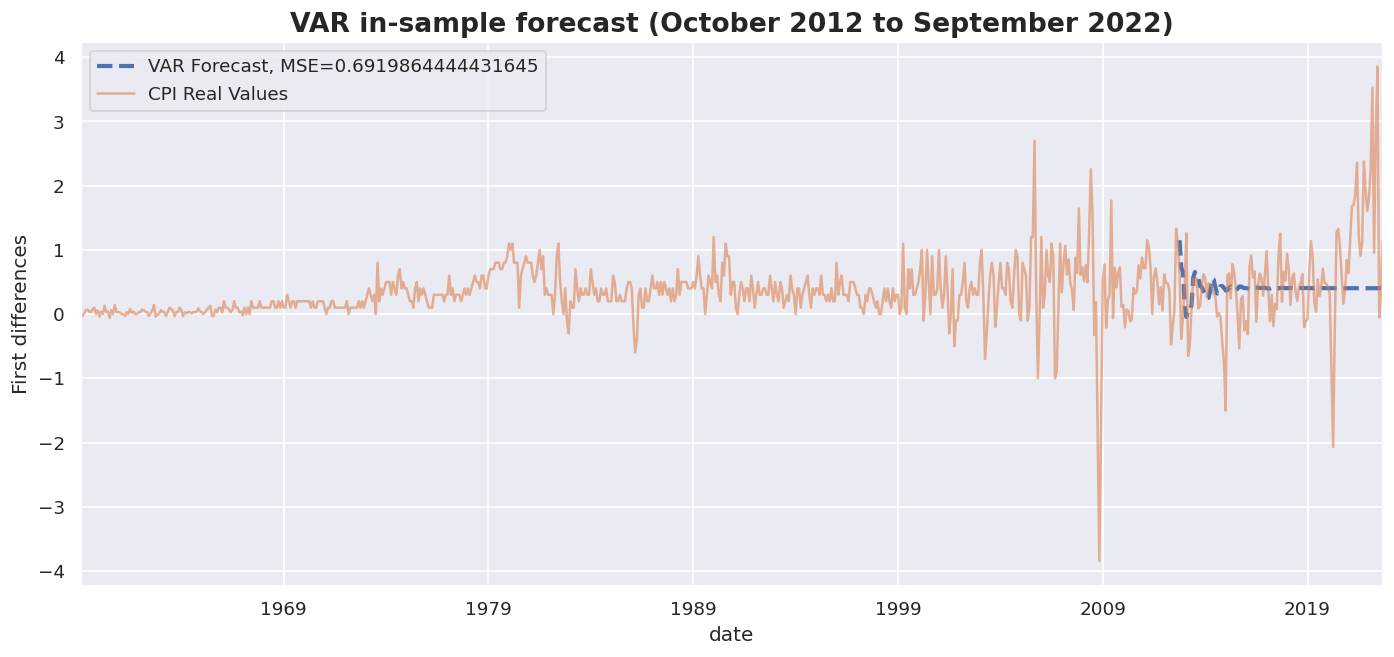

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
colors = sns.color_palette("deep", 8)

# final_data1["CPI_diff_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
# final_data1['CPI_diff'].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")

forecasted["CPI_diff_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
df1['CPI_diff'].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")

ax.set_title("VAR in-sample forecast (October 2012 to September 2022)", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="center")
ax.set_ylabel("First differences", fontname="Verdana")
ax.legend([f"VAR Forecast, MSE={mse1}", "CPI Real Values"])
plt.show()

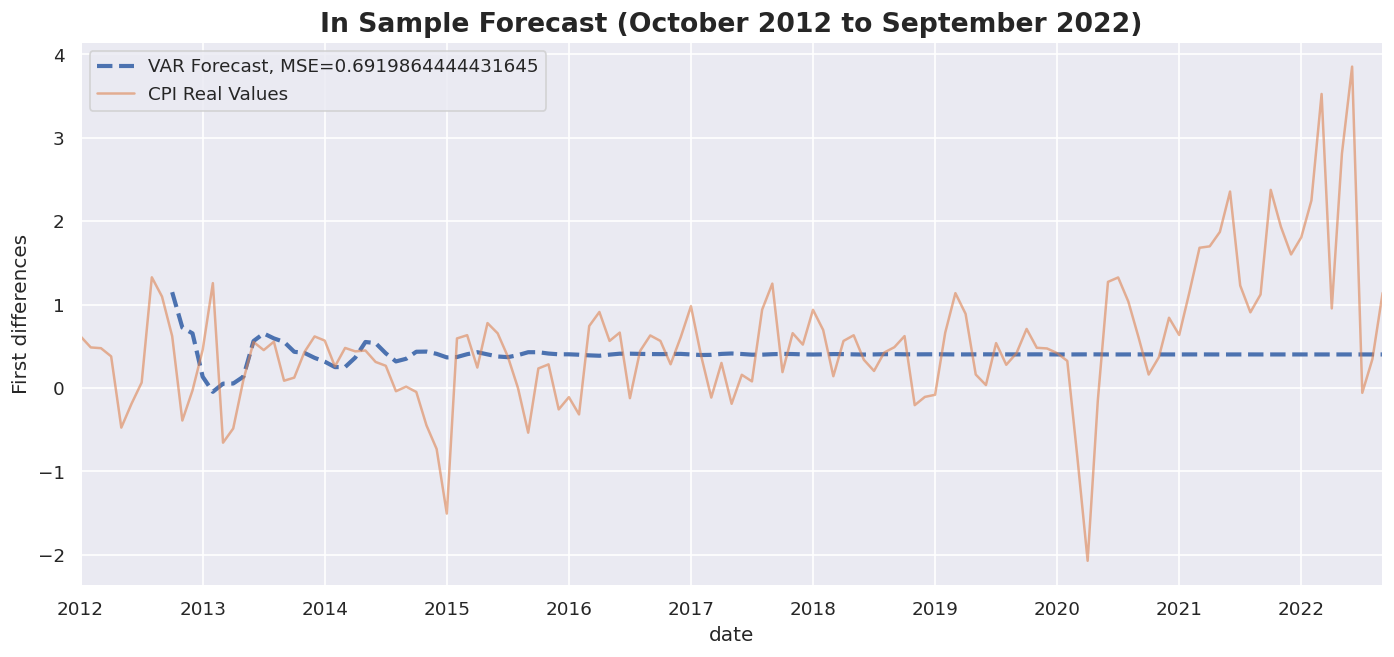

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
colors = sns.color_palette("deep", 8)

forecasted.loc["2012-01":"2022-09", 'CPI_diff_fcast'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
df1.loc["2012-01":"2022-09", 'CPI_diff'].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")

ax.set_title("In Sample Forecast (October 2012 to September 2022)", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="center")
ax.set_ylabel("First differences", fontname="Verdana")
ax.legend([f"VAR Forecast, MSE={mse1}", "CPI Real Values"])
plt.show()



### Prediction from February 2018 to January 2019

The VAR model uses 4 variables: Consumer Price Index, real personal income, unemployment rate, Fed Funds rate and Stock Price Index.

The VAR model uses 9 lags for each variable and predicts each variable from Feb 2018 to Jan 2019.
$B$ represents a matrix of coefficients.


$$
\begin{bmatrix} \\ cpi_{t} \\ rpi_{t} \\ unemp_{t} \\ fedrate_{t}\\ S\&P_{t}\end{bmatrix} = \alpha_t + B_{t-1}\begin{bmatrix} \\cpi_{t-1} \\ rpi_{t-1} \\ unemp_{t-1} \\ fedrate_{t-1}\\ S\&P_{t-1} \end{bmatrix} + \dots + B_{t-9}\begin{bmatrix} \\cpi_{t-9} \\ rpi_{t-9} \\ unemp_{t-9} \\ fedrate_{t-9}\\ S\&P_{t-9} \end{bmatrix}+ \epsilon_t
$$


In [ ]:
data = df1.dropna(axis=0)

# Split dataset and run VAR on the trained part
data_train = data.loc["1976-01":"2018-02", :]# Train:32 yrs, #test:12 mnths
var_train = VAR(data_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
#Initiate VAR model
# model = VAR(endog=X_train_log_diff)
res = var_train.select_order(15)
res.summary()

,AIC,BIC,FPE,HQIC
0,13.69,13.73,8.824e+05,13.71
1,8.726,8.983*,6162.,8.827
2,8.547,9.018,5154.,8.732*
3,8.503,9.187,4932.,8.772
4,8.480,9.377,4818.,8.832
5,8.498,9.609,4907.,8.934
6,8.505,9.830,4945.,9.026
7,8.508,10.05,4963.,9.113
8,8.458*,10.21,4720.*,9.146
9,8.480,10.45,4833.,9.252


lag order = 1, acc to BIC

In [ ]:
forecasted

In [ ]:

results = var_train.fit(9)
lag_order = results.k_ar
forecasted = pd.DataFrame(results.forecast(data_train.values[-lag_order:], 12)) # Forecast 12 months

# Rename forecasted columns
forecasted_names = list(forecasted.columns.values)
data_train_names = list(data_train.columns.values)

var_dict = dict(zip(forecasted_names, data_train_names))

for f,t in var_dict.items():
    forecasted = forecasted.rename(columns={f:t + "_fcast"})

months3 = pd.period_range(start_date_3, end_date_, freq='M')
forecasted['months']=months3
forecasted.set_index('months', inplace=True)

# Parse together forecasted data with original dataset
# final_data2 = pd.merge(forecasted, data, left_index=True, right_index=True)
# final_data2 = final_data2.sort_index(axis=0, ascending=True)
# final_data2 = pd.concat([data_train, final_data2], sort=True, axis=0)
# final_data2 = final_data2.sort_index(axis=0, ascending=True)

var_mse = metrics.mean_squared_error(forecasted.dropna(axis=0).loc[start_date_3:end_date_,"CPI_diff_fcast"], 
                        df1.dropna(axis=0).loc[start_date_3:end_date_,"CPI_diff"])


# final = var_create(df1)

In [ ]:
df1

,RPI_diff,CPI_diff,FEDFUNDS_diff,S&P_diff,UNRATE
date,,,,,
1959-02-01,9.620,-0.010,-0.05,-0.85,5.9
1959-03-01,15.816,-0.030,0.37,1.39,5.6
1959-04-01,16.077,0.010,0.16,0.94,5.2
1959-05-01,14.355,0.060,-0.06,0.86,5.1
1959-06-01,7.762,0.070,0.49,-0.50,5.0
...,...,...,...,...,...
2022-05-01,-7.928,2.811,0.44,-350.94,3.6
2022-06-01,-72.740,3.854,0.44,-141.41,3.6
2022-07-01,90.349,-0.057,0.47,12.78,3.5


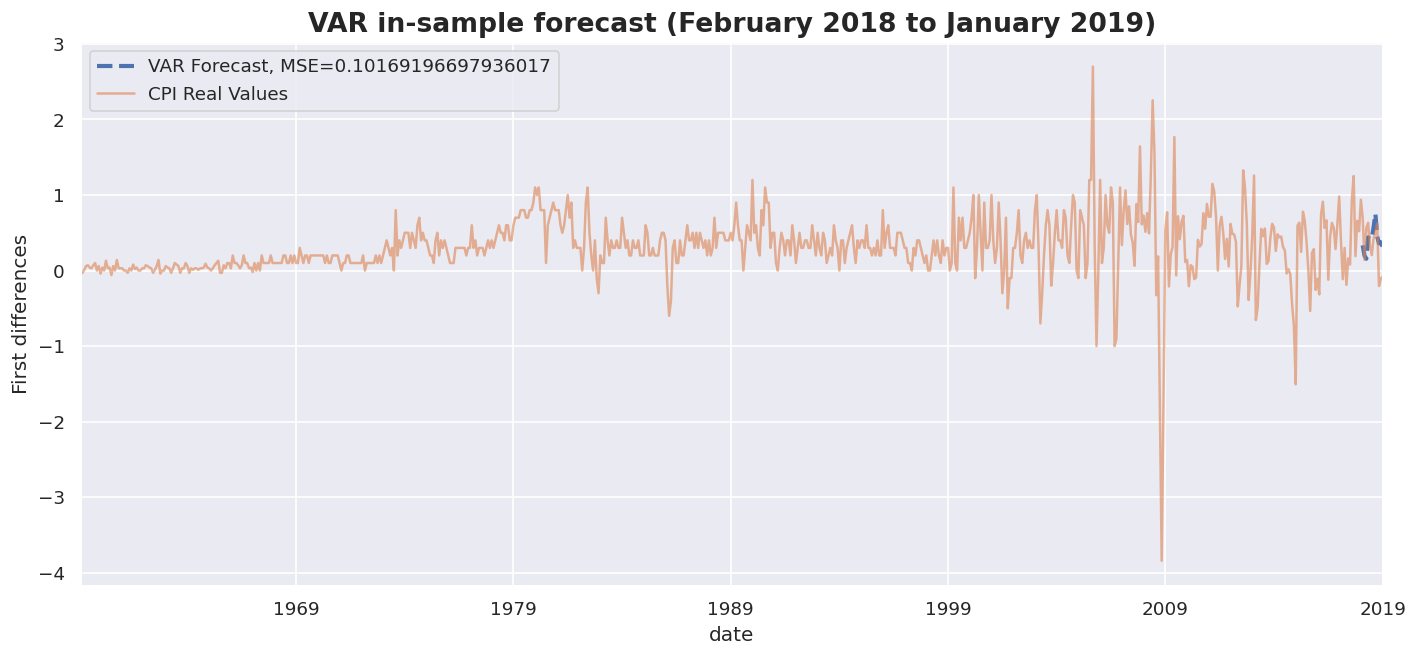

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
colors = sns.color_palette("deep", 8)

forecasted.loc[:, 'CPI_diff_fcast'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
df1.loc[:"2019-01", 'CPI_diff'].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")

ax.set_title("VAR in-sample forecast (February 2018 to January 2019)", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="center")
ax.set_ylabel("First differences", fontname="Verdana")
ax.legend([f"VAR Forecast, MSE={var_mse}", "CPI Real Values"])
plt.show()

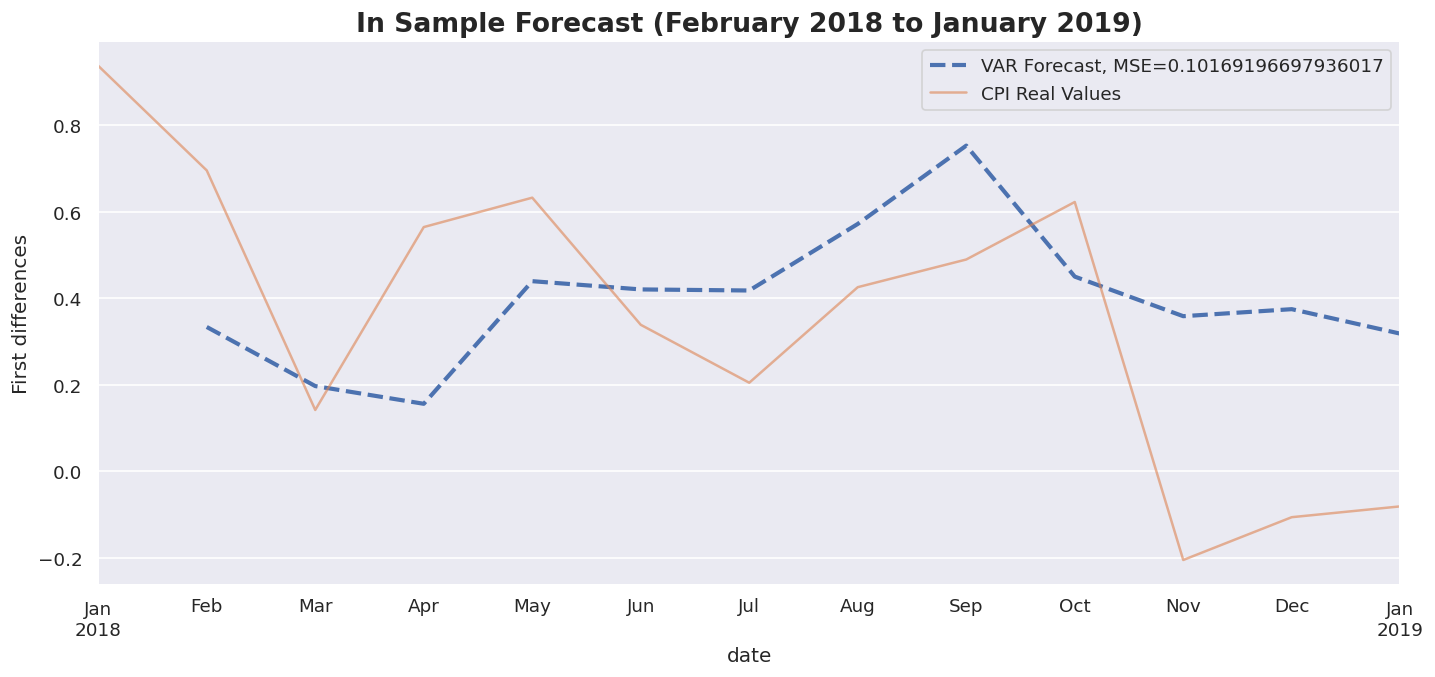

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
colors = sns.color_palette("deep", 8)

forecasted.loc["2018-01":"2019-01", 'CPI_diff_fcast'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
df1.loc["2018-01":"2019-01", 'CPI_diff'].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")

ax.set_title("In Sample Forecast (February 2018 to January 2019)", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="center")
ax.set_ylabel("First differences", fontname="Verdana")
ax.legend([f"VAR Forecast, MSE={var_mse}", "CPI Real Values"])
plt.show()



## Vector Error Correction Model

### Feb 2018 to Jan 2019

In [ ]:
start_date1 = datetime.datetime.strptime("1976-02", '%Y-%m')
start_date_3 = datetime.datetime.strptime("2018-02", '%Y-%m')

end_date_ = datetime.datetime.strptime('2019-01', '%Y-%m')

In [ ]:
# data1 = df1.dropna(axis=0)

# Split dataset and run VAR on the trained part
# data_train = df1.loc["1976-01":"2012-01", :]# Train:36, #test:10
data_train = df.loc["1976-01":"2012-01", :]# Train:36, #test:10


In [ ]:
vec_rank1 = vecm.select_coint_rank(data_train, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank1.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5          123.3          87.77
  1   5          76.20          62.52
  2   5          29.55          41.08
-------------------------------------


In [ ]:
vec_rank2 = vecm.select_coint_rank(data_train, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(vec_rank2.summary())
print('Number of cointegrated variables:',vec_rank2.rank)

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          47.06          42.86
  1   2          46.65          36.19
  2   3          18.46          29.26
-------------------------------------
Number of cointegrated variables: 2


In [ ]:
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import select_order

lag_order = select_order(data=df, maxlags=10, deterministic="ci", seasons=4)
lag_order.aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

10

In [ ]:
# from statsmodels.tsa.vector_ar.vecm import VECM

model = VECM(df.loc["1976-01":"2018-02", :], deterministic="ci", seasons=4, coint_rank=4) 
vecm_res = model.fit()
vecm_res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,coef,std err,z,P>|z|,[0.025,0.975]
season1,-5.838e-05,2.96e-05,-1.973,0.048,-0.000,-3.94e-07
season2,-7.008e-05,2.97e-05,-2.363,0.018,-0.000,-1.19e-05
season3,-3.999e-05,2.96e-05,-1.350,0.177,-9.81e-05,1.81e-05
L1.RPI,-0.1858,0.044,-4.258,0.000,-0.271,-0.100
L1.UNRATE,-0.0479,0.011,-4.309,0.000,-0.070,-0.026
L1.S&P 500,0.0095,0.012,0.825,0.409,-0.013,0.032
L1.CPI,-0.1991,0.104,-1.908,0.056,-0.404,0.005
L1.FEDFUNDS,3.017e-05,0.003,0.009,0.993,-0.006,0.006
,coef,std err,z,P>|z|,[0.025,0.975]
season1,-4.007e-05,0.000,-0.337,0.736,-0.000,0.000


In [ ]:
vecm_res.predict(steps=12, alpha=0.05)

forecast, lower, upper = vecm_res.predict(12, 0.05)
print('lower bounds of confidence intervals:')
print(lower.round(3))
print('\npoint forecasts:')
print(forecast.round(3))
print('\nupper bounds of confidence intervals:')
print(upper.round(3))

# vecm = VECM(endog = data_train, k_ar_diff = 9, coint_rank = 4)
# vecm_fit = vecm.fit()
# vecm_fit.predict(steps=10)



lower bounds of confidence intervals:
[[ 0.059  0.022  0.074  0.058  0.002]
 [ 0.059  0.02   0.074  0.058 -0.003]
 [ 0.059  0.019  0.073  0.058 -0.007]
 [ 0.059  0.018  0.073  0.058 -0.009]
 [ 0.059  0.017  0.073  0.058 -0.011]
 [ 0.06   0.016  0.073  0.058 -0.013]
 [ 0.06   0.015  0.073  0.058 -0.014]
 [ 0.06   0.014  0.072  0.058 -0.015]
 [ 0.06   0.014  0.072  0.058 -0.016]
 [ 0.06   0.013  0.072  0.058 -0.017]
 [ 0.06   0.012  0.072  0.058 -0.018]
 [ 0.06   0.011  0.072  0.058 -0.018]]

point forecasts:
[[0.059 0.023 0.076 0.058 0.007]
 [0.06  0.023 0.077 0.058 0.007]
 [0.06  0.022 0.077 0.058 0.006]
 [0.06  0.022 0.077 0.059 0.006]
 [0.06  0.021 0.078 0.059 0.006]
 [0.061 0.021 0.078 0.059 0.006]
 [0.061 0.02  0.078 0.059 0.006]
 [0.061 0.02  0.078 0.059 0.006]
 [0.061 0.019 0.079 0.059 0.006]
 [0.061 0.019 0.079 0.059 0.006]
 [0.062 0.018 0.08  0.059 0.006]
 [0.062 0.018 0.08  0.059 0.006]]

upper bounds of confidence intervals:
[[0.06  0.025 0.078 0.059 0.013]
 [0.06  0.026 0.07

In [ ]:
# vecm_for = vecm_res.predict(steps=12, alpha=0.05)[0]
# vecm_lower = vecm_res.predict(steps=12, alpha=0.05)[1]
# vecm_upper = vecm_res.predict(steps=12, alpha=0.05)[2]


In [ ]:
# vecm_for

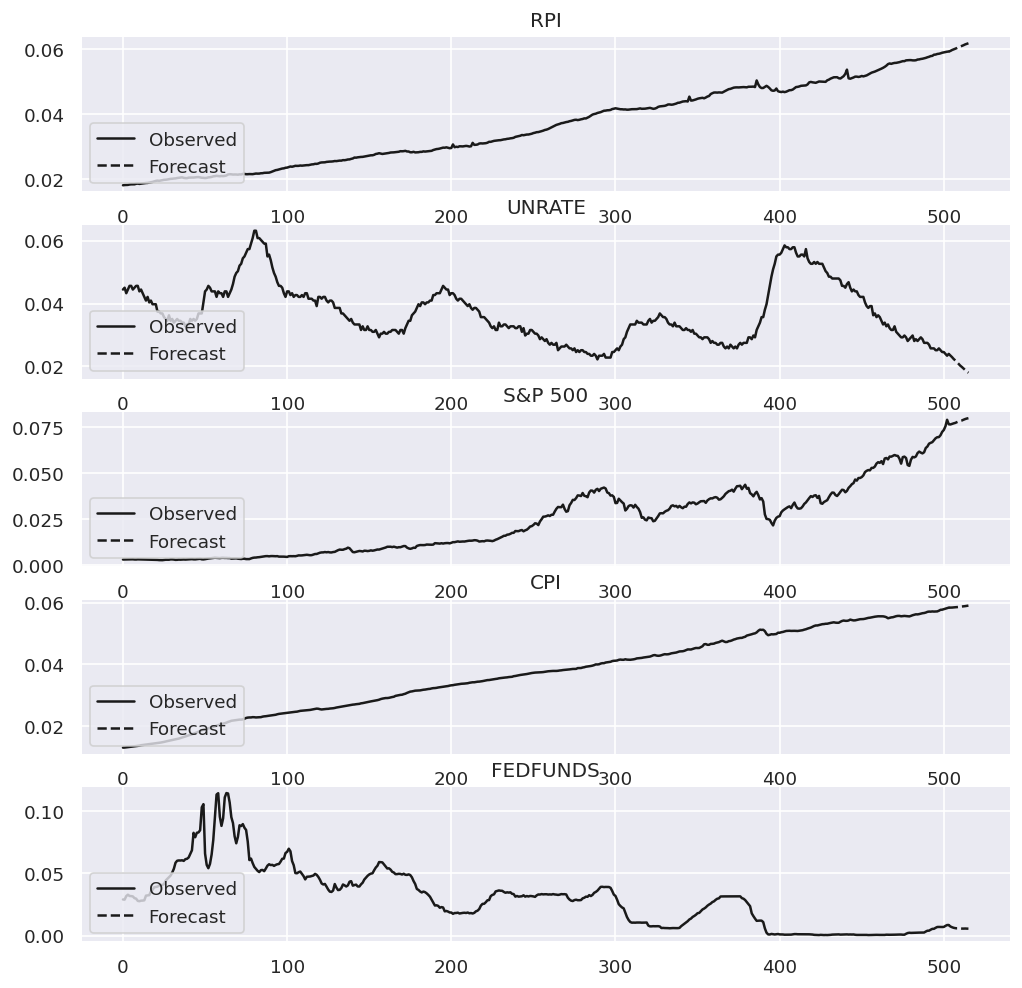

In [ ]:
vecm_res.plot_forecast(steps=12, plot_conf_int=False)

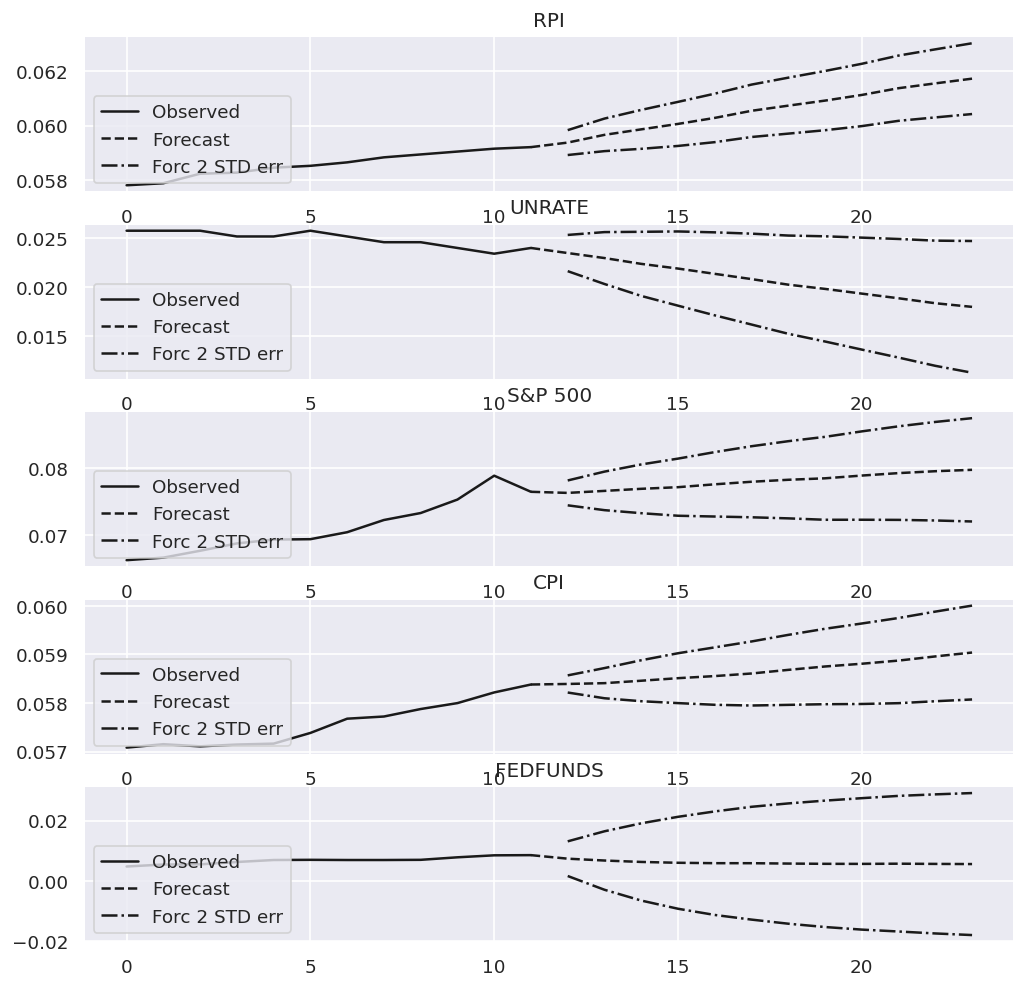

In [ ]:
vecm_res.plot_forecast(steps=12, alpha = 0.05, n_last_obs=12)

In [ ]:
# end_date

In [ ]:
# data_train

In [ ]:
vecm_for = vecm_res.predict(steps=12, alpha=0.05)[0]
vecm_for = pd.DataFrame(vecm_for) # Forecast 120 months


# # Rename forecasted columns
vecm_for_names = list(vecm_for.columns.values)
data_train_names = list(data_train.columns.values)

vecm_dict = dict(zip(vecm_for_names, data_train_names))

for f,t in vecm_dict.items():
    vecm_for = vecm_for.rename(columns={f:t + "_fcast"})

months = pd.period_range('2018-02', '2019-01', freq='M')
vecm_for['months']=months
vecm_for.set_index('months', inplace=True)

# # Parse together forecasted data with original dataset
# vecm_fin = pd.merge(vecm_for, df1, left_index=True, right_index=True)
# vecm_fin = vecm_fin.sort_index(axis=0, ascending=True)
# vecm_fin = pd.concat([data_train, vecm_fin], sort=True, axis=0)
# vecm_fin = vecm_fin.sort_index(axis=0, ascending=True)

mse_vecm = metrics.mean_squared_error(vecm_for.loc[start_date_3:end_date_,"CPI_fcast"].iloc[1:], 
                        df.loc[start_date_3:end_date_,"CPI"].iloc[1:])

In [ ]:
# vecm_fin.loc[start_date_3:end_date_,"CPI_diff"].iloc[1:]

In [ ]:
# months

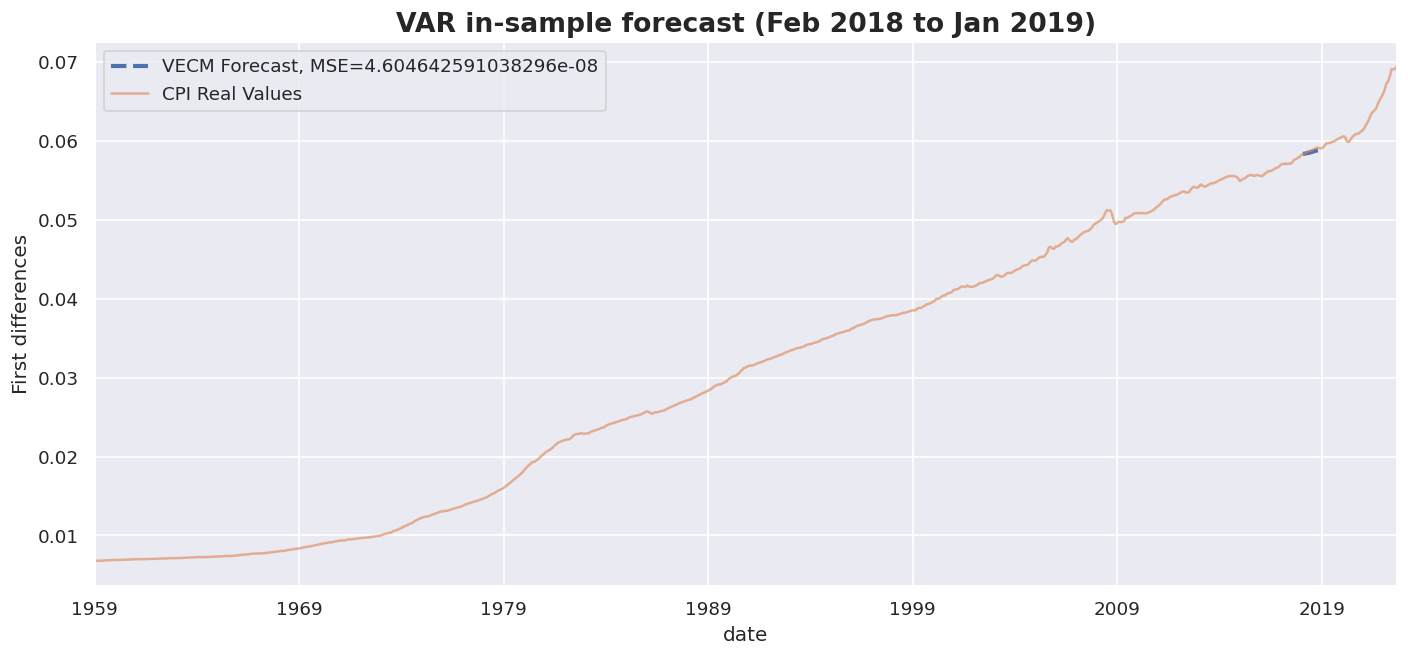

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
colors = sns.color_palette("deep", 8)
vecm_for["CPI_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
df['CPI'].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")
ax.set_title("VAR in-sample forecast (Feb 2018 to Jan 2019)", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="center")
ax.set_ylabel("First differences", fontname="Verdana")
ax.legend([f"VECM Forecast, MSE={mse_vecm}", "CPI Real Values"])
plt.show()

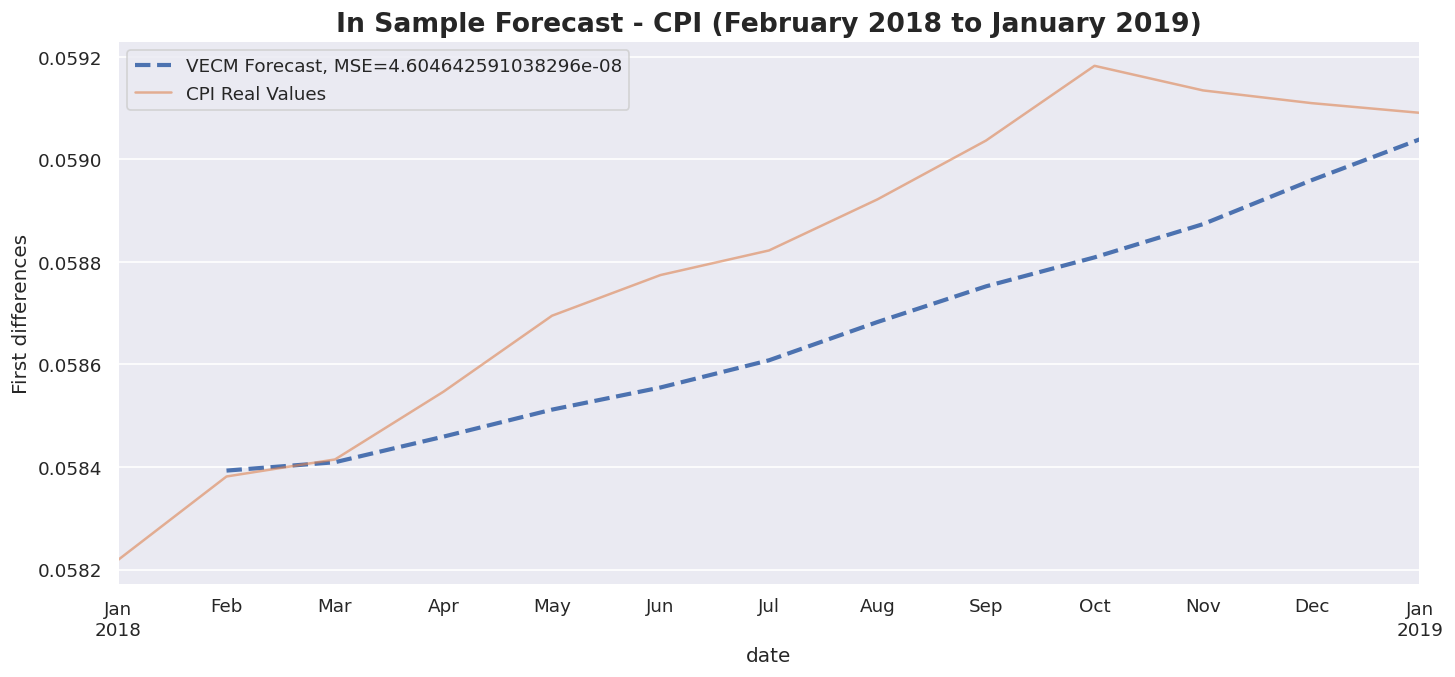

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
colors = sns.color_palette("deep", 8)

vecm_for.loc["2018-01":"2019-01", 'CPI_fcast'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
df.loc["2018-01":"2019-01", 'CPI'].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")

ax.set_title("In Sample Forecast - CPI (February 2018 to January 2019)", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="center")
ax.set_ylabel("First differences", fontname="Verdana")
ax.legend([f"VECM Forecast, MSE={mse_vecm}", "CPI Real Values"])
plt.show()



# Conclusions

From this exercise, we have learned that there's a fundamental difference between prediction/fit and forecasting. 
* The project provides us with a clear idea about the existing cointegration between the macroeconomic variables.
* While the historical prediction of a model might be very good and training the model on a test dataset might yield high MSEs, forecasting with those same features is tricky. 
* Since variables in VAR interact endogenously with each other, there's much uncertainty with how the selected features will trend over time. Thus the use of VECM helps forecast.
* When it comes to forecasting, one needs to decide which variables are the most important and not just rely solely on fit. 

* To be precise Vector Error Correction Model yields phenomenal results due to the presence of cointegration.

A summary of the MSEs between actual and forecasted values for each approach is provided below. 

After this exercise, I find that the VAR model works really well, however VECM is more suited for tackling the problem. 

**Scope of Further Work**
* In terms of policy implications, there is still value in looking to economic theory (such as the **Phillips Curve**) to assist in forecasting.
* The variables used in the model are significantly correlated and the results are quite pleasing, however this also signifies that there must exist more cointegrated variables.